# <span style="color:orange"> *Multiple bounded optimization* </span> 

In [1]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import subprocess
import sys
import pandas as pd
import os

 # <span style="color:lime"> *Repository & Tool loading* </span>
 Remember to check that it says the exact commit you should be working on </br>
 ### *This only needs to be run once, then the folder will be created*

In [2]:
%cd susceptibility-to-fieldmap-fft 
!git status
!git checkout d9f785b
%pip install .

[Errno 2] No such file or directory: 'susceptibility-to-fieldmap-fft'
/Users/soothsayer7/msc_rios/sus-optimization/susceptibility-to-fieldmap-fft
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Note: switching to 'd9f785b'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at d9f785b Fix bug
Processing /Users/soothsayer7/msc_rios/sus-optimization/susceptibility-to-fieldmap-fft
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'susceptibility-to-field

In [3]:
home_path = r"C:\Users\Admin\Documents\msc_project\Image-processing-strategies\chi_opt"
#Once we confirmed the head of the chi to fbfest we can go to home
%cd {home_path}
!ls

C:\Users\Admin\Documents\msc_project\Image-processing-strategies\chi_opt
chi_opt_demod_32.ipynb
chi_opt_demod_33.ipynb
chi_opt_demod_35.ipynb
demod.py
shazam_requirements.txt
susceptibility-to-fieldmap-fft
tissue-to-MRproperty
utils


In [4]:
path_to_chi_to_fm_fft = r"C:\Users\Admin\Documents\msc_project\Image-processing-strategies\chi_opt\susceptibility-to-fieldmap-fft"
sys.path.append(path_to_chi_to_fm_fft)
#sys.path.append('/Users/evaalonsoortiz/Documents/python/susceptibility-to-fieldmap-fft/')
from functions import compute_fieldmap

In [5]:
#Function to automate the subprocess of extractiing measure with SCT through the terminal
from utils.extract_metric import extract_metrics
# This function is only useful if you want to print and display while optimizing
# Example of calling the function:
#extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_metric_mask, out_B0_metrics_path, method='wa', vert="3:15") # Change numbers x:y accordingly

 # <span style="color:silver"> *Data analysis* </span> 

In [7]:
# Define the run nfolder name
run_number = "test1_powell"

In [ ]:
# Everytime you run the code, it will create a new folder with the run number and restart the counter
path_to_iter_fms = r"E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms"
path_to_iter_metrics = r"E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics"


path_to_iter_fms = os.path.join(path_to_iter_fms,run_number)
path_to_iter_metrics = os.path.join(path_to_iter_metrics,run_number)
counter = 0

#########
# This don't change, this are used with the simulation's FOV
path_to_sim_metric_mask = "E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz"
path_to_dmod_mask = "E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz"
path_to_chimap = "E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/B1_chi_maps/dB0_033_mod0.nii.gz" # -4.36 (past value)
path_to_segs = "E:\msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/final_merged_wb_segs.nii.gz"


##  <span style="color:#C133FF"> *Performing demodulation on measured!* </span> 

In [9]:
import importlib
import utils.demod   # your custom module (e.g., my_module.py)
importlib.reload(utils.demod)
from utils.demod import demod_Hz

In [35]:
# load it:
db0_033_avg_dmod_metric_values_df = pd.read_csv(r"E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\dB0_033_avg_dmod_meas_metrics_c5t7.csv")
# This is the one used in the optimization loop!
# Goes from 5 to 14

In [36]:
# Check the values:
db0_033_avg_dmod_metric_values = db0_033_avg_dmod_metric_values_df['WA()']
db0_033_avg_dmod_metric_values

0    -53.312953
1     14.442740
2     93.797890
3    127.060660
4     79.966874
5     47.420091
6     45.571511
7     49.048168
8     48.554811
9     35.809311
Name: WA(), dtype: float64

There seemed to be an outlayer on the measured, the value of T8 is -64.76999841554219 </br>
Given the values before, it looks like an error </br>
After evaluation of the fieldmap, this looks like a compromised region of the fieldmap, we should use until T7 with this subject


In [57]:
central_freq_exp_db33 = 123.249489 # in MHz 
gamma_bar = 42.58 # MHz/T
B0 = 3 # [T]
B0_used_scanner = central_freq_exp_db33 /gamma_bar
print("The B0 to use in the simulation should be: ", B0_used_scanner, "T")


The B0 to use in the simulation should be:  2.8945394316580555 T


### <span style="color:chocolate"> *In case you want to compare in a plot!* </span> 

In [58]:
path_to_zero_ref_ppm_sim_fm = r"E:\msc_data\ismrm_2025\dB0_033_dup1\fm\sim\fms\dB0_033_sim_fm_ppm.nii.gz"
path_to_zero_ref_ppm_sim_metrics = r"E:\msc_data\ismrm_2025\dB0_033_dup1\fm\sim\fms\dB0_033_sim_fm_ppm_c5t7.csv"
extract_metrics(path_to_zero_ref_ppm_sim_fm, path_to_dmod_mask, path_to_sim_metric_mask, path_to_zero_ref_ppm_sim_metrics, method = 'wa', vert = "5:14")

Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\sim\fms\dB0_033_sim_fm_ppm.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\sim\fms\dB0_033_sim_fm_ppm_c5t7.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\sim\fms\dB0_033_sim_fm_ppm_c5t7.csv

Total runtime; 8.196 seconds.



In [60]:
zero_ref_dB0_035_sim_df = pd.read_csv(path_to_zero_ref_ppm_sim_metrics)
zero_ref_dB0_035_sim = zero_ref_dB0_035_sim_df["WA()"][::-1]
zero_ref_dB0_035_sim

9   -3.493181
8   -3.275605
7   -3.000930
6   -2.917393
5   -3.139957
4   -3.260650
3   -3.222482
2   -3.162634
1   -3.221189
0   -3.241913
Name: WA(), dtype: float64

In [61]:
# Go to Hz using the central frequency from the scanner:
test_zero_ref_dB0_035_sim_Hz = zero_ref_dB0_035_sim * central_freq_exp_db33
test_zero_ref_dB0_035_sim_Hz

9   -430.532740
8   -403.716641
7   -369.863142
6   -359.567163
5   -386.998124
4   -401.873430
3   -397.169265
2   -389.792986
1   -397.009943
0   -399.564075
Name: WA(), dtype: float64

In [62]:
dmod_sim_value = np.mean(test_zero_ref_dB0_035_sim_Hz)
print("The dmod_sim_value is: ", dmod_sim_value, "Hz")

The dmod_sim_value is:  -393.6087509464706 Hz


In [63]:
test_dmod_zero_ref_dB0_035_sim_Hz = test_zero_ref_dB0_035_sim_Hz - dmod_sim_value
test_dmod_zero_ref_dB0_035_sim_Hz

9   -36.923989
8   -10.107890
7    23.745609
6    34.041588
5     6.610627
4    -8.264679
3    -3.560514
2     3.815764
1    -3.401192
0    -5.955324
Name: WA(), dtype: float64

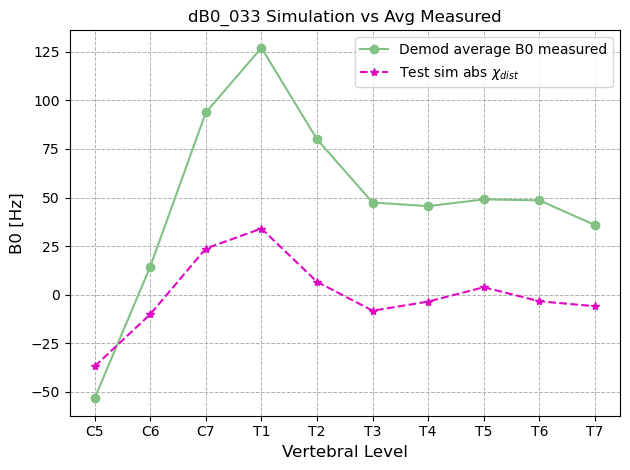

In [56]:
# With that done we can plot them:
vertebrae_levels_meas = ['C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'] # From 5 to 15
vertebrae_levels = ['C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7','T8'] # From 5 to 15
plt.plot(vertebrae_levels_meas, db0_033_avg_dmod_metric_values, marker = 'o', linestyle = '-', label = "Demod average B0 measured", color = "#81C184")
plt.plot(vertebrae_levels_meas, test_dmod_zero_ref_dB0_035_sim_Hz, marker = '*', linestyle = '--', label = r"Test sim abs $\chi_{dist}$", color = "#E008C3")

title = "dB0_033 Simulation vs Avg Measured"
plt.title(title)
plt.xlabel('Vertebral Level', fontsize=12)
plt.ylabel('B0 [Hz]', fontsize=12)
plt.legend()
# Customize grid and display
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

#yticks = range(-450, 450, 100) 
#plt.yticks(yticks)

# Show the plot
plt.show()

 # <span style="color:gold"> *Optimization loop!* </span> </br>
 With the graphs working as we expect them too, lets begin chi optimization

In [31]:
history = [] 
history_chi_trachea = []
history_chi_lungs = []

In [30]:
# Loading dependencies outside obj. function to decrease computational needs

# Load the simulated susceptibility map in ppm
sim_chi_img = nib.load(path_to_chimap)
sim_chi_data = sim_chi_img.get_fdata()

# Load segmentation labels that create the chimaps
ROI_img = nib.load(path_to_segs)
ROI_data = ROI_img.get_fdata()

# Find indices with the labels we want to update
ind_trachea = np.where((ROI_data == 8))
ind_lungs = np.where((ROI_data == 7))
#ind_body = np.where((ROI_data == 2))
#ind_bone = np.where((ROI_data == 3))

dmod_sim_mask = nib.load(path_to_dmod_mask).get_fdata()

vertebrae_levels_opt = ['C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'] # From 5 to 14

In [ ]:
def f_simple_double_opt(x):

    global counter # This works? 
    
    counter += 1  
    print('$$$$$$$$$$$$$$$$$$$$$$$$$')
    print(f"Iteration #{counter}")
    print(f"Chi for trachea: {x[0]}")
    print(f"Chi for lungs: {x[1]}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")
    
    # Assign variables 
    # Now we get only 1 value 
    chi_internal_air = 0.27 # ppm in SI units 
    chi_trachea = x[0]
    chi_lungs = x[1]

    sim_chi_data[ind_trachea] = chi_trachea
    sim_chi_data[ind_lungs] = chi_lungs
    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res, affine_matrix = compute_fieldmap.load_sus_dist(path_to_chimap)

    sim_b0_ppm =  compute_fieldmap.compute_bz(sim_chi_data, image_resolution = image_res, buffer = 50) #, mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_Hz = sim_b0_ppm * central_freq_exp_db33
    
    chi1_name = str(str(float(f"{chi_trachea:.3f}"))).replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi_lungs:.3f}"))).replace(".","_")
    #chi_3_name = str(str(float(f"{chi_internal_air:.3f}"))).replace(".","_")

    # Just in case you want to check the chimaps created: ###################################
    #chi_map_name = f"chimap_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz"
    # Load where you want to save them, and dont forget to use the same run number :)
    # And don't forget to actually create the run# folder 
    #path_to_iterchimaps = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/chimaps_extra/run14"
    #chimap_img = nib.Nifti1Image(sim_chi_data, affine = sim_chi_img.affine)
    #chimap_save_dir = os.path.join(path_to_iterchimaps, chi_map_name)
    #nib.save(chimap_img, chimap_save_dir)
    ##########################################################################################
    sim_b0_Hz_name = f"sim_dmod_fm_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz"
    iter_fm_save_dir = os.path.join(path_to_iter_fms, sim_b0_Hz_name)
    # Now before saving the new fieldmap, lets demodulate with the SC mask
    iter_demod_value = np.mean(sim_b0_Hz[dmod_sim_mask==1])
    print(f"For iteration #{counter} using {iter_demod_value}")
    demod_iter_fm_Hz = sim_b0_Hz - iter_demod_value

    sim_b0_Hz_img = nib.Nifti1Image(demod_iter_fm_Hz, affine = sim_chi_img.affine )
    nib.save(sim_b0_Hz_img, iter_fm_save_dir)

    # Now we extract metrics 
    metrics_name = f"metrics_sim_dmod_fm_tr_{chi1_name}_l_{chi2_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_iter_metrics, metrics_name)
    vert = "5:14"
    extract_metrics(iter_fm_save_dir, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method = 'wa', vert = vert)

    metric_values = pd.read_csv(path_to_out_metrics)
    sim_fm_vert_values = metric_values['WA()'][::-1]
    
    # This is a test to see if chi value changes

    #crop_sim_values = dmod_sim_vert_values.iloc[[0,4,7]].values
    #print("### Sim Cropped:")
    #print(crop_sim_values)
    #print(type(crop_sim_values))
    #crop_meas_values = avg_resp_b0meas_values.iloc[[0,4,7]].values


    # Dunno how to have options in the objective fucntion so this if is manual lmao
    #if norm_type == "L2":
    difference_l2 = np.linalg.norm(db0_033_avg_dmod_metric_values - sim_fm_vert_values ) # This is the L2 norm
    difference = difference_l2
    print("Difference: ", difference)

    #crop_dif =  np.linalg.norm(crop_sim_values - crop_meas_values)
    #crop_dif = np.sum(np.abs(crop_sim_values)-np.abs(crop_meas_values))
    #print("Minimizing difference - L1 Norm: ", crop_dif)
    #difference = crop_dif
    #elif norm_type == "L1":
    #difference_L1 = np.sum(np.abs(avg_resp_b0meas_values)- np.abs(dmod_sim_vert_values))
    #difference =difference_L1
    #print("Minimizing difference - L1 Norm: ", difference_L1)

    plt.clf() # Clear the plot to only have 1 in the output
    plt.plot(vertebrae_levels_opt, sim_fm_vert_values, marker = 'o', linestyle = '--', label = f"Dmod Simulated", color = "#EC3838")  
    plt.plot(vertebrae_levels_opt, db0_033_avg_dmod_metric_values, marker = 'o', linestyle = '-', label = "Dmod In-vivo meas", color = "#264cff") 
    plt.title(f"$\\chi$ of trachea: {chi1_name} & Lung: {chi2_name} with Powell method")
    plt.xlabel('Vertebral Level', fontsize=12)
    plt.ylabel('B0 [Hz]', fontsize=12)
    plt.legend()

    yticks = range(-100, 0, 150) 
    plt.yticks(yticks)

    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.tight_layout()

# Show the plot
    plt.show()

# Trying to show convergence plot
    error = db0_033_avg_dmod_metric_values - sim_fm_vert_values
    loss = np.linalg.norm(error)
    history.append(loss)
    history_chi_trachea.append(chi_trachea)
    history_chi_lungs.append(chi_lungs)

    return difference


 # <span style="color:#1FC7AB"> *Optimization results!* </span> </br>

In [33]:
# Before running please verify your outpaths:
print(path_to_iter_fms)
print(path_to_iter_metrics)

E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell
E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell


In [34]:
# Reset counter if neceesary (alone verrsion)
# This should be done when defining new paths but sometimes can be overridden
# Use with care
counter

0

In [ ]:
counter = 0
counter

Creating run folders
Folders created:  E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell
$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #1
Chi for trachea: -2.0
Chi for lungs: -4.2
For iteration #1 using -376.2593348316366
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-2_0_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-2_0_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-2_0_l_-4_2_Hz.csv

Total runtime; 10.205 seconds.

Difference:  25

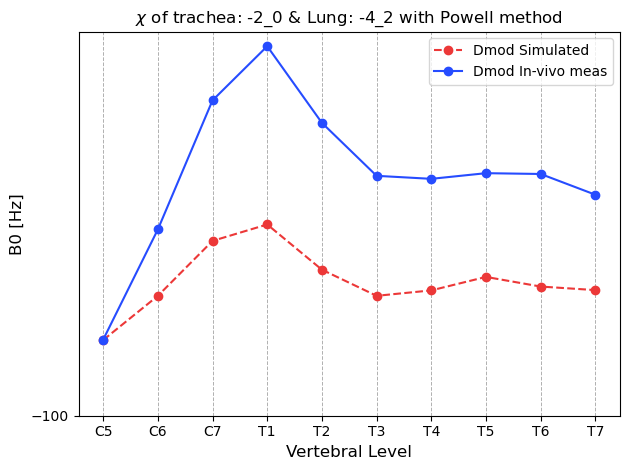

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #2
Chi for trachea: -6.721980673998823
Chi for lungs: -4.2
For iteration #2 using -376.2503686710183
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-6_722_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-6_722_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-6_722_l_-4_2_Hz.csv

Total runtime; 9.943 seconds.

Difference:  256.9826787813067


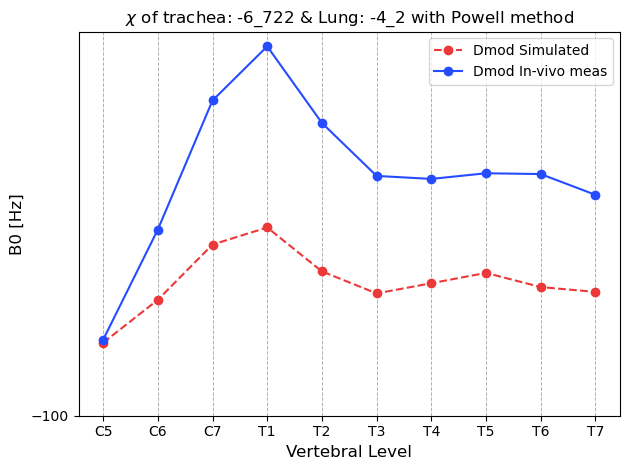

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #3
Chi for trachea: -4.078019326001179
Chi for lungs: -4.2
For iteration #3 using -376.2553890605013
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-4_078_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-4_078_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-4_078_l_-4_2_Hz.csv

Total runtime; 9.867 seconds.

Difference:  258.1960064301954


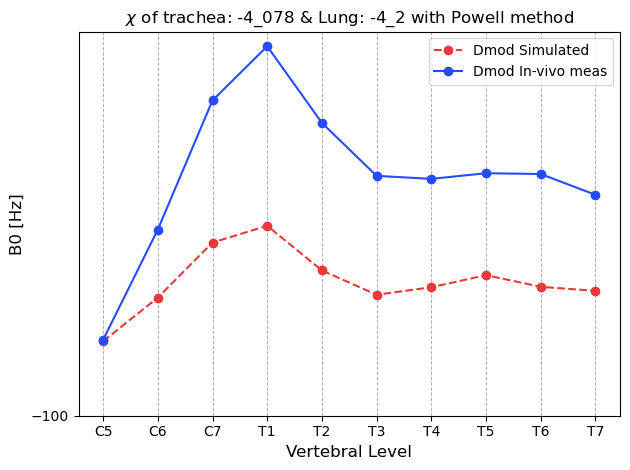

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #4
Chi for trachea: -8.356038652002356
Chi for lungs: -4.2
For iteration #4 using -376.24726589968105
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-8_356_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-8_356_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-8_356_l_-4_2_Hz.csv

Total runtime; 9.918 seconds.

Difference:  256.2586694165424


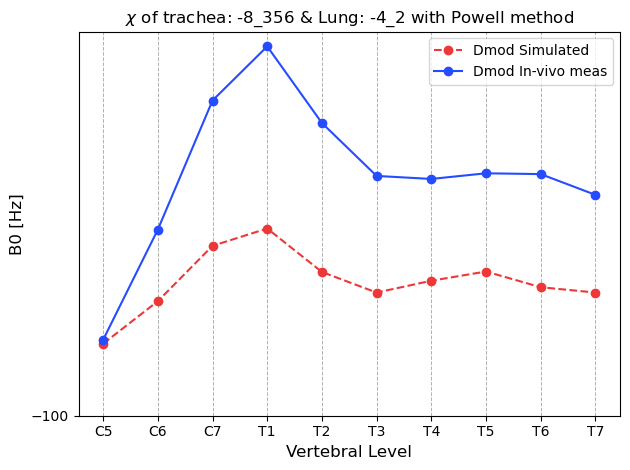

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #5
Chi for trachea: -9.365942021996467
Chi for lungs: -4.2
For iteration #5 using -376.2453482815353
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-9_366_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_366_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_366_l_-4_2_Hz.csv

Total runtime; 9.954 seconds.

Difference:  255.82117896724404


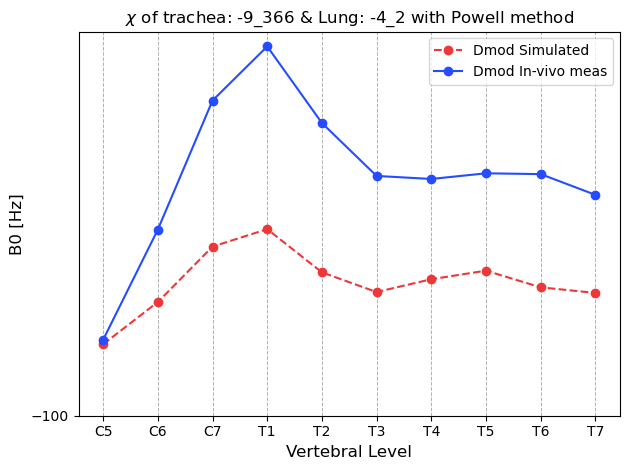

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #6
Chi for trachea: -9.990096630005889
Chi for lungs: -4.2
For iteration #6 using -376.24416312834376
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-9_99_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_99_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_99_l_-4_2_Hz.csv

Total runtime; 9.886 seconds.

Difference:  255.55462513743268


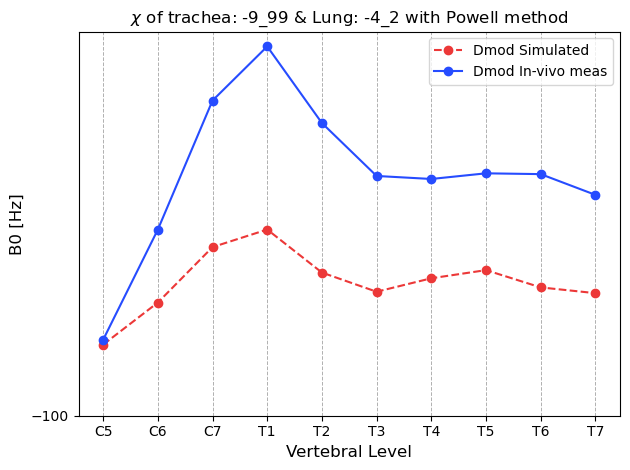

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #7
Chi for trachea: -10.375845391990579
Chi for lungs: -4.2
For iteration #7 using -376.2434306633896
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_376_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_376_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_376_l_-4_2_Hz.csv

Total runtime; 9.900 seconds.

Difference:  255.39135374795728


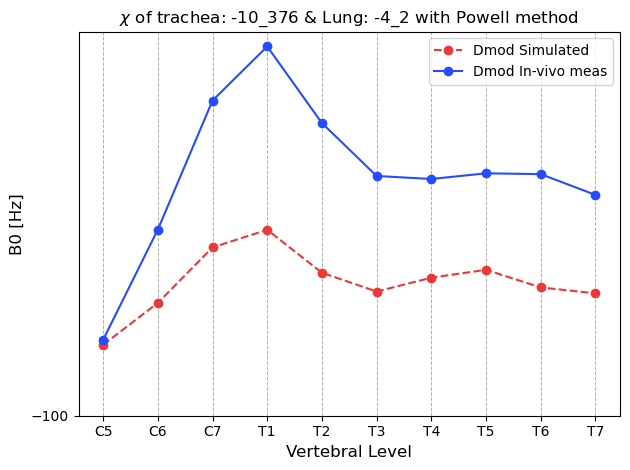

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #8
Chi for trachea: -10.61425123801531
Chi for lungs: -4.2
For iteration #8 using -376.24297797515226
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_614_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_614_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_614_l_-4_2_Hz.csv

Total runtime; 9.918 seconds.

Difference:  255.29100834441752


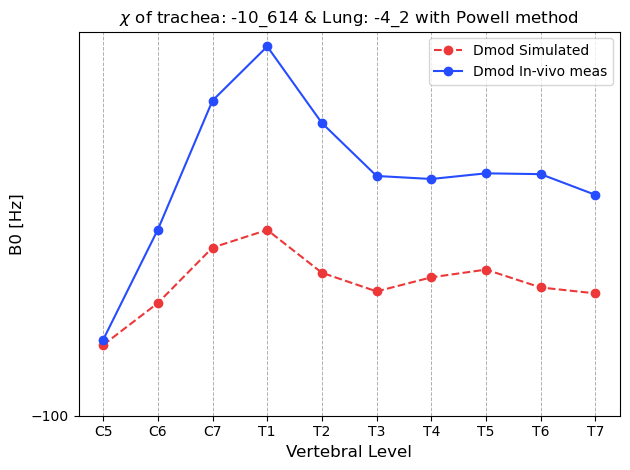

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #9
Chi for trachea: -10.761594153975269
Chi for lungs: -4.2
For iteration #9 using -376.24269819843533
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_762_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_762_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_762_l_-4_2_Hz.csv

Total runtime; 9.876 seconds.

Difference:  255.22920636091604


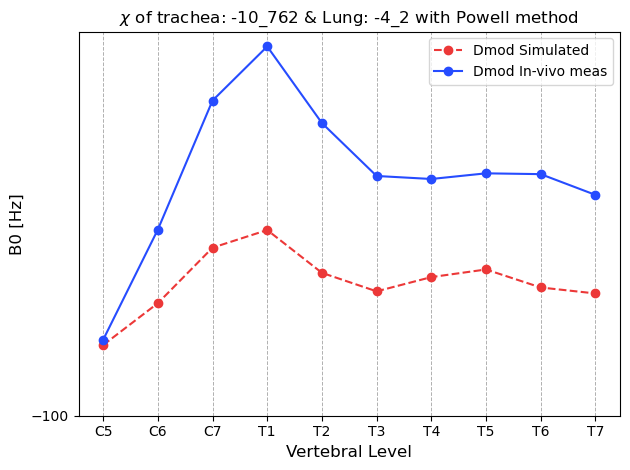

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #10
Chi for trachea: -10.852657084040041
Chi for lungs: -4.2
For iteration #10 using -376.24252528691494
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_853_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_853_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_853_l_-4_2_Hz.csv

Total runtime; 9.841 seconds.

Difference:  255.19109277824867


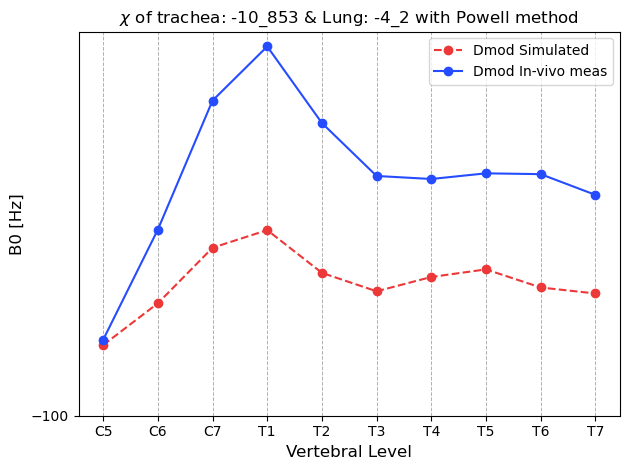

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #11
Chi for trachea: -10.908937069935225
Chi for lungs: -4.2
For iteration #11 using -376.24241842171836
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_909_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_909_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_909_l_-4_2_Hz.csv

Total runtime; 9.861 seconds.

Difference:  255.16756868000402


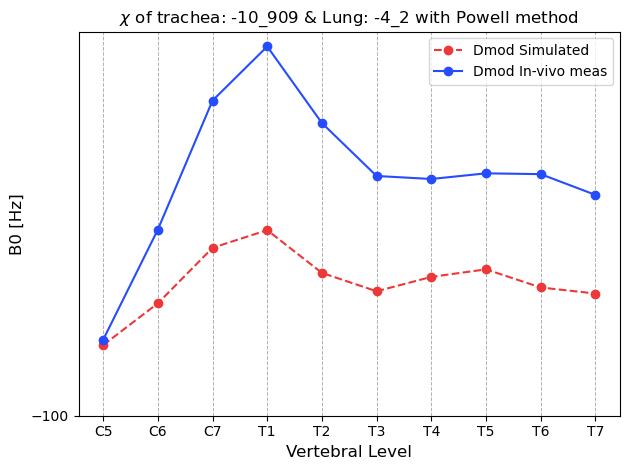

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #12
Chi for trachea: -10.943720014104814
Chi for lungs: -4.2
For iteration #12 using -376.24235237539466
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_944_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_944_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_944_l_-4_2_Hz.csv

Total runtime; 9.872 seconds.

Difference:  255.15304198171327


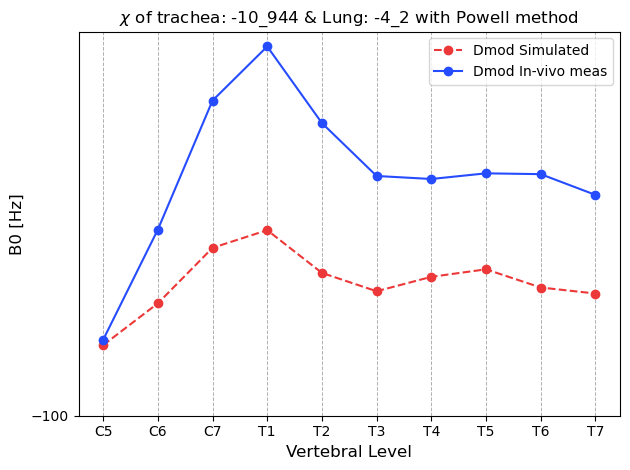

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #13
Chi for trachea: -10.96521705583041
Chi for lungs: -4.2
For iteration #13 using -376.24231155652177
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_965_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_965_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_965_l_-4_2_Hz.csv

Total runtime; 9.887 seconds.

Difference:  255.14406857056196


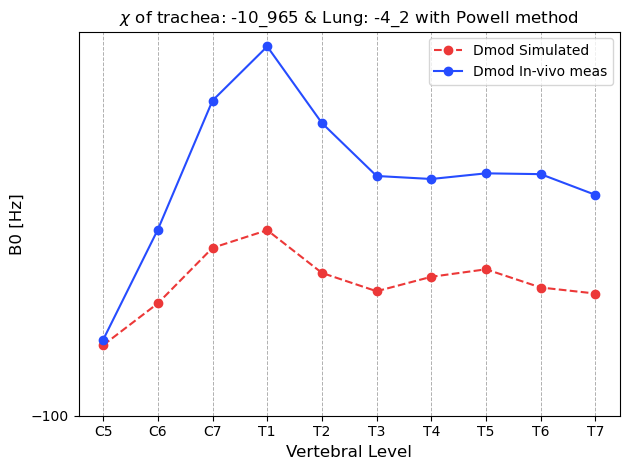

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #14
Chi for trachea: -10.978502958274403
Chi for lungs: -4.2
For iteration #14 using -376.24228632907096
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_979_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_979_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_979_l_-4_2_Hz.csv

Total runtime; 9.928 seconds.

Difference:  255.13852444789498


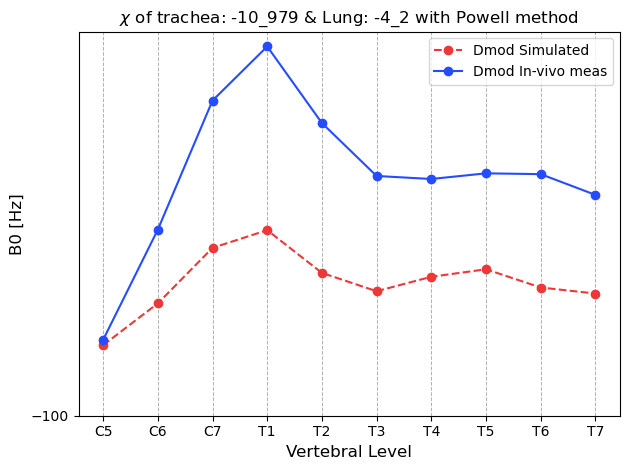

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #15
Chi for trachea: -10.986714097556007
Chi for lungs: -4.2
For iteration #15 using -376.2422707376488
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_987_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_987_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_987_l_-4_2_Hz.csv

Total runtime; 9.741 seconds.

Difference:  255.13509866029705


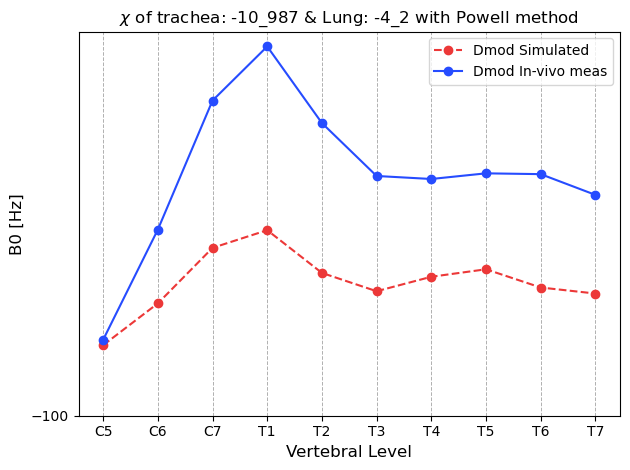

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #16
Chi for trachea: -10.991788860718398
Chi for lungs: -4.2
For iteration #16 using -376.2422611016201
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_992_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_992_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_992_l_-4_2_Hz.csv

Total runtime; 9.959 seconds.

Difference:  255.13298166253483


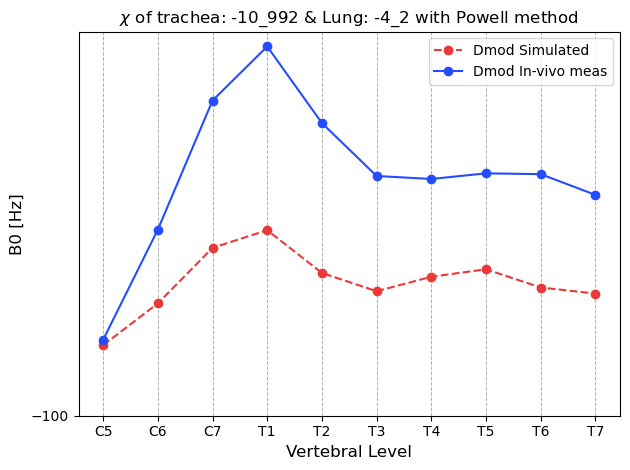

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #17
Chi for trachea: -10.994925236837611
Chi for lungs: -4.2
For iteration #17 using -376.2422551462268
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_995_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_995_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_995_l_-4_2_Hz.csv

Total runtime; 9.813 seconds.

Difference:  255.13167338352508


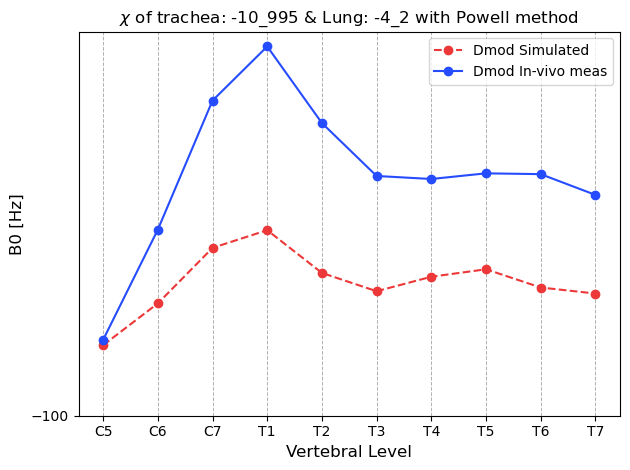

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #18
Chi for trachea: -10.996863623880788
Chi for lungs: -4.2
For iteration #18 using -376.2422514655913
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_997_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_997_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_997_l_-4_2_Hz.csv

Total runtime; 12.482 seconds.

Difference:  255.130864859896


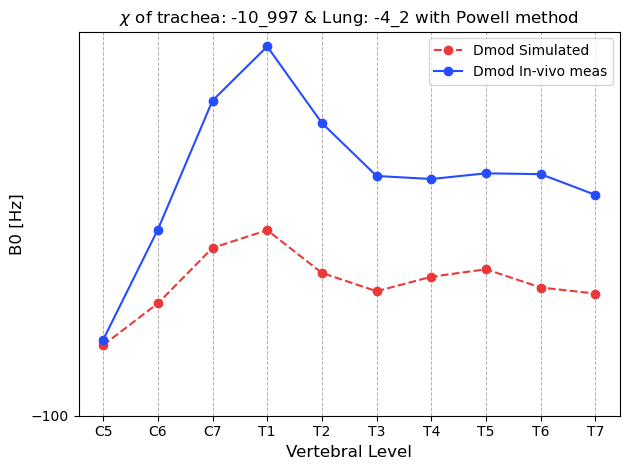

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #19
Chi for trachea: -10.998061612956823
Chi for lungs: -4.2
For iteration #19 using -376.24224919083355
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_998_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_998_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_998_l_-4_2_Hz.csv

Total runtime; 9.905 seconds.

Difference:  255.13036517904678


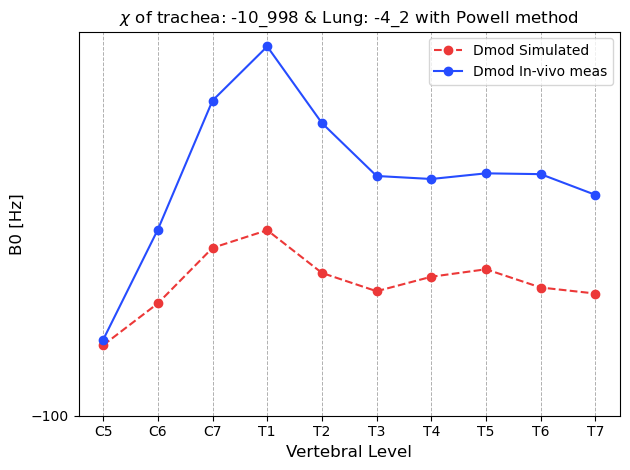

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #20
Chi for trachea: -10.998802010923963
Chi for lungs: -4.2
For iteration #20 using -376.2422477849559
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_999_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-4_2_Hz.csv

Total runtime; 9.973 seconds.

Difference:  255.13005636473554


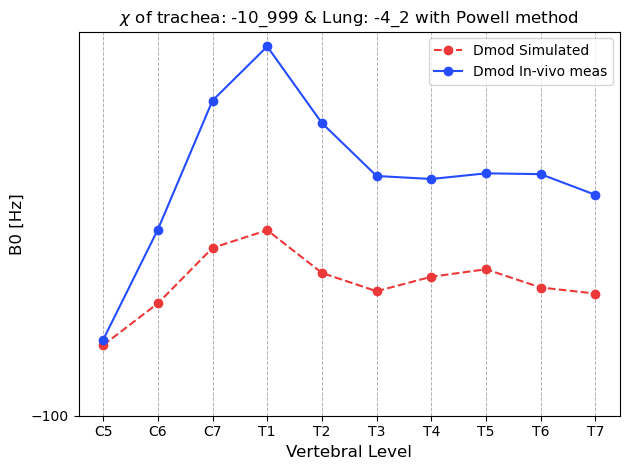

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #21
Chi for trachea: -10.999259602032858
Chi for lungs: -4.2
For iteration #21 using -376.24224691607566
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_999_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-4_2_Hz.csv

Total runtime; 9.720 seconds.

Difference:  255.12986550907195


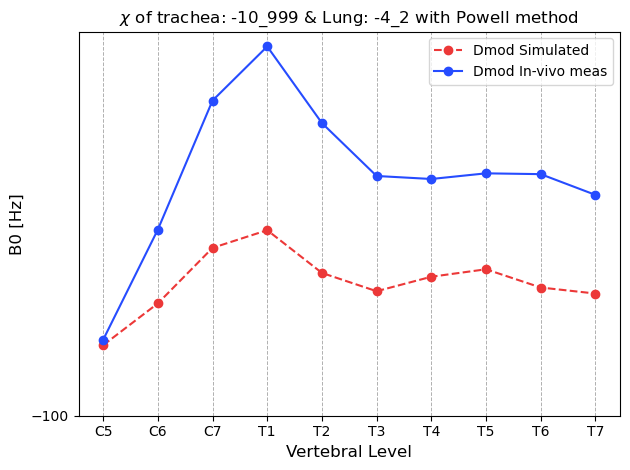

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #22
Chi for trachea: -10.999542408891104
Chi for lungs: -4.2
For iteration #22 using -376.24224637907815
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_2_Hz.csv

Total runtime; 9.848 seconds.

Difference:  255.12974755457816


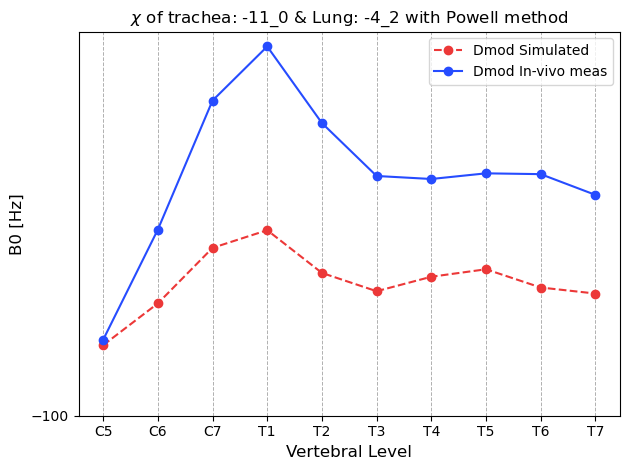

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #23
Chi for trachea: -10.999717193141752
Chi for lungs: -4.2
For iteration #23 using -376.2422460471955
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_2_Hz.csv

Total runtime; 9.782 seconds.

Difference:  255.12967465499474


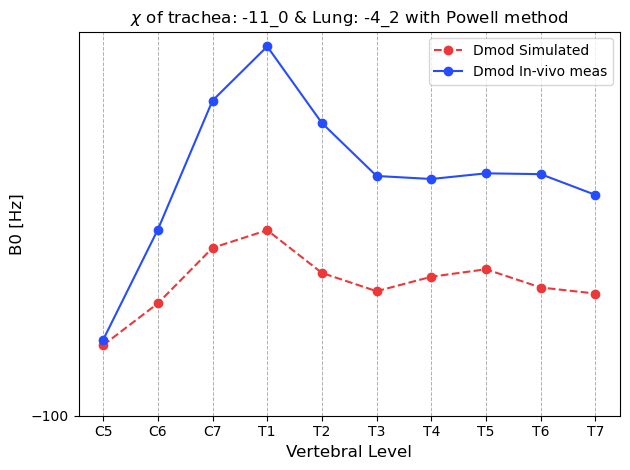

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #24
Chi for trachea: -10.99982521574935
Chi for lungs: -4.2
For iteration #24 using -376.2422458420807
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_2_Hz.csv

Total runtime; 9.772 seconds.

Difference:  255.12962960069035


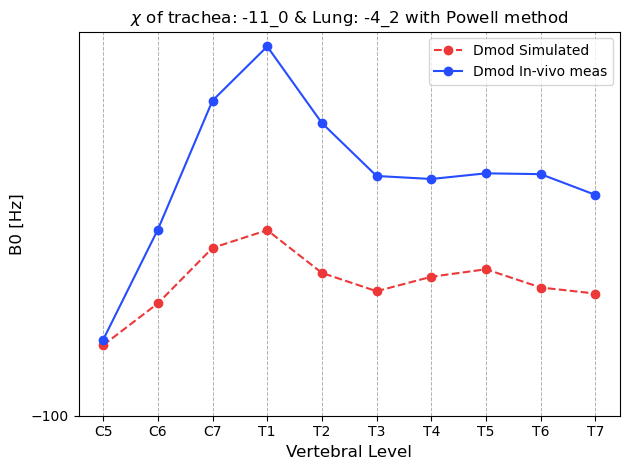

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #25
Chi for trachea: -10.9998919773924
Chi for lungs: -4.2
For iteration #25 using -376.24224571531283
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_2_Hz.csv

Total runtime; 9.774 seconds.

Difference:  255.12960175564282


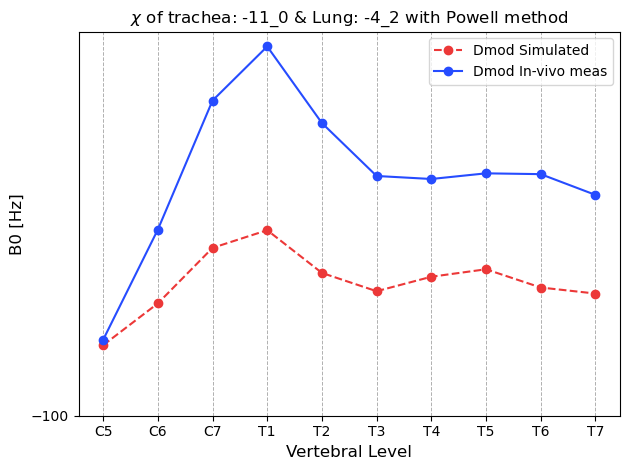

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #26
Chi for trachea: -10.999933238356949
Chi for lungs: -4.2
For iteration #26 using -376.24224563696595
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_2_Hz.csv

Total runtime; 9.806 seconds.

Difference:  255.129584546474


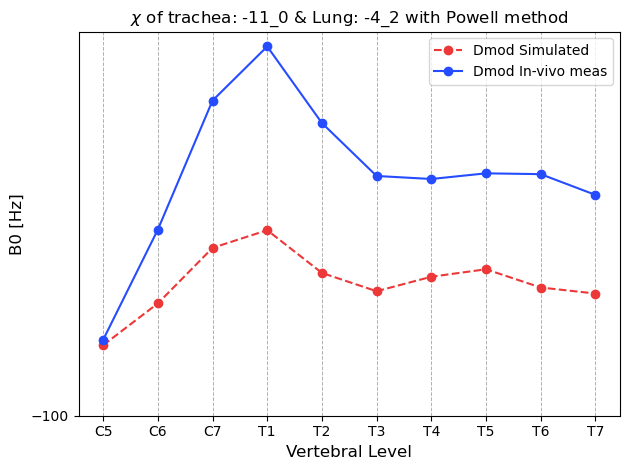

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #27
Chi for trachea: -10.999933238356949
Chi for lungs: -3.0137767414994534
For iteration #27 using -376.0016561530028
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-3_014_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-3_014_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-3_014_Hz.csv

Total runtime; 9.836 seconds.

Difference:  266.3842524284146


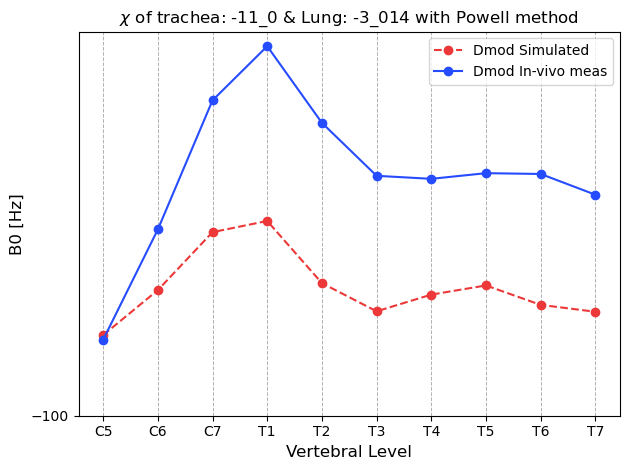

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #28
Chi for trachea: -10.999933238356949
Chi for lungs: -1.7862232585005469
For iteration #28 using -375.7526840839632
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-1_786_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-1_786_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-1_786_Hz.csv

Total runtime; 9.833 seconds.

Difference:  280.885377410653


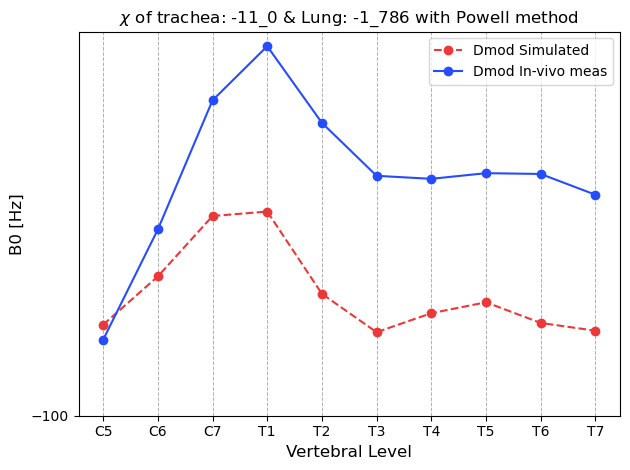

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #29
Chi for trachea: -10.999933238356949
Chi for lungs: -3.7724465170010935
For iteration #29 using -376.1555293539188
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-3_772_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-3_772_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-3_772_Hz.csv

Total runtime; 9.865 seconds.

Difference:  258.8490039223056


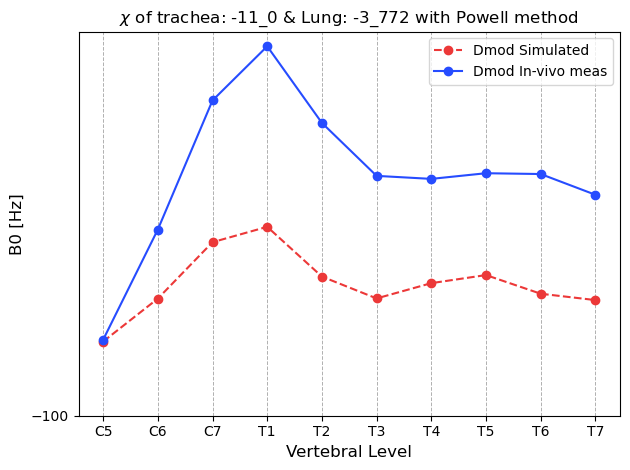

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #30
Chi for trachea: -10.999933238356949
Chi for lungs: -4.24133022449836
For iteration #30 using -376.25062822204245
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_241_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_241_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_241_Hz.csv

Total runtime; 9.824 seconds.

Difference:  254.79106178112846


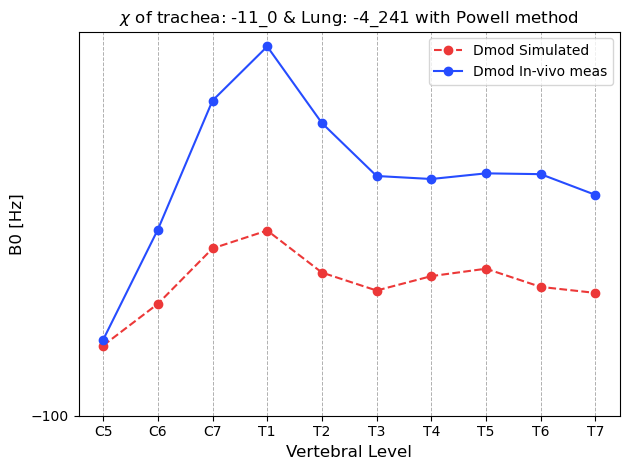

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #31
Chi for trachea: -10.999933238356949
Chi for lungs: -4.531116292502734
For iteration #31 using -376.30940255483466
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_531_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_531_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_531_Hz.csv

Total runtime; 9.867 seconds.

Difference:  252.52418622461818


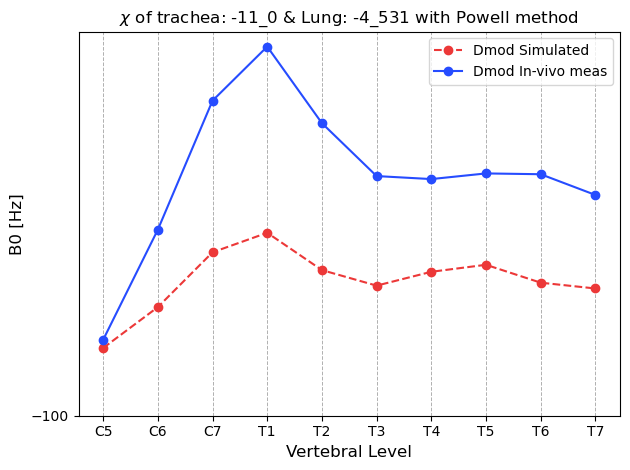

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #32
Chi for trachea: -10.999933238356949
Chi for lungs: -4.710213931995626
For iteration #32 using -376.34572709016624
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_71_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_71_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_71_Hz.csv

Total runtime; 9.806 seconds.

Difference:  251.21800431872683


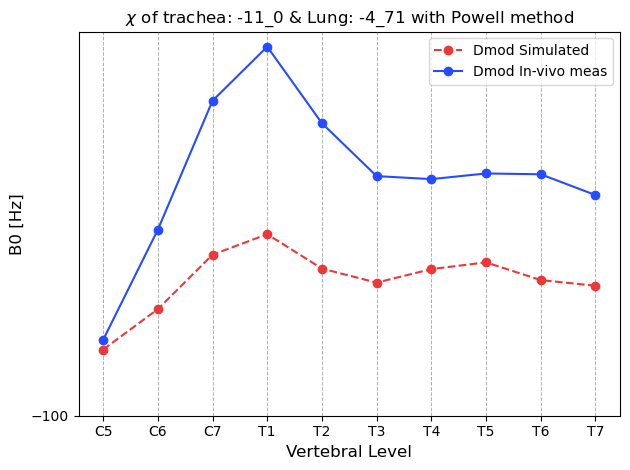

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #33
Chi for trachea: -10.999933238356949
Chi for lungs: -4.820902360507108
For iteration #33 using -376.3681768876267
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_821_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_821_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_821_Hz.csv

Total runtime; 9.800 seconds.

Difference:  250.44757890859708


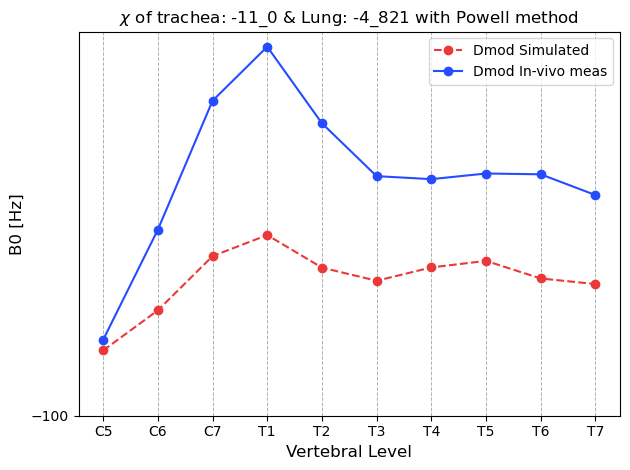

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #34
Chi for trachea: -10.999933238356949
Chi for lungs: -4.889311571488517
For iteration #34 using -376.38205162549787
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_889_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_889_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_889_Hz.csv

Total runtime; 9.827 seconds.

Difference:  249.98564283730778


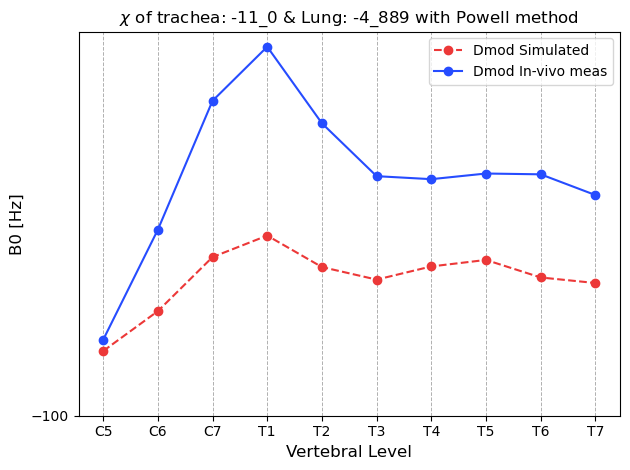

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #35
Chi for trachea: -10.999933238356949
Chi for lungs: -4.931590789018591
For iteration #35 using -376.39062668508717
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_932_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_932_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_932_Hz.csv

Total runtime; 9.840 seconds.

Difference:  249.70561222529744


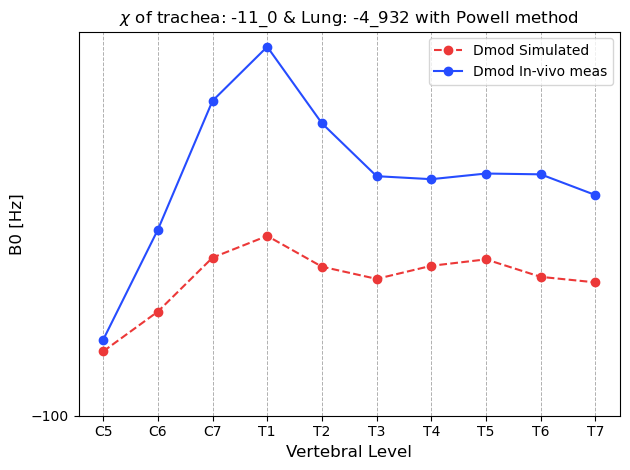

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #36
Chi for trachea: -10.999933238356949
Chi for lungs: -4.957720782469926
For iteration #36 using -376.395926363369
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_958_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_958_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_958_Hz.csv

Total runtime; 9.809 seconds.

Difference:  249.53463753150956


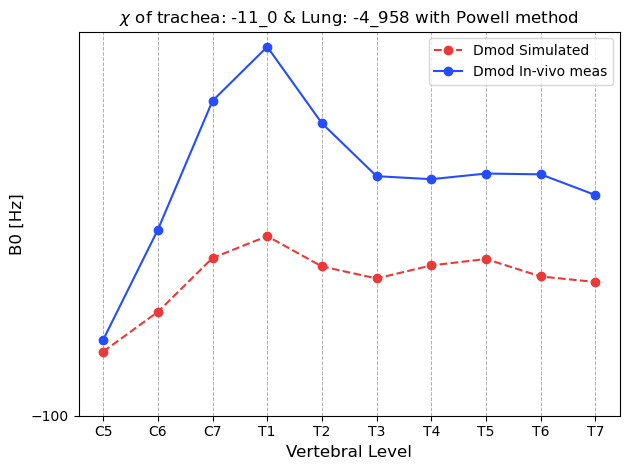

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #37
Chi for trachea: -10.999933238356949
Chi for lungs: -4.9738700065486645
For iteration #37 using -376.3992017446766
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_974_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_974_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_974_Hz.csv

Total runtime; 9.777 seconds.

Difference:  249.4297708760676


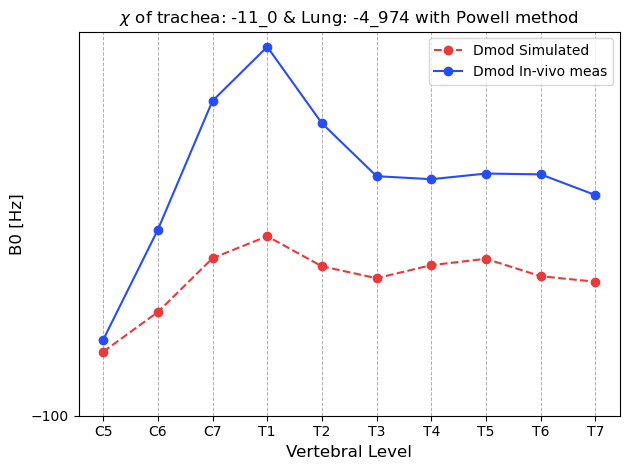

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #38
Chi for trachea: -10.999933238356949
Chi for lungs: -4.983850775921262
For iteration #38 using -376.4012260416508
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_984_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_984_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_984_Hz.csv

Total runtime; 9.856 seconds.

Difference:  249.36526628803557


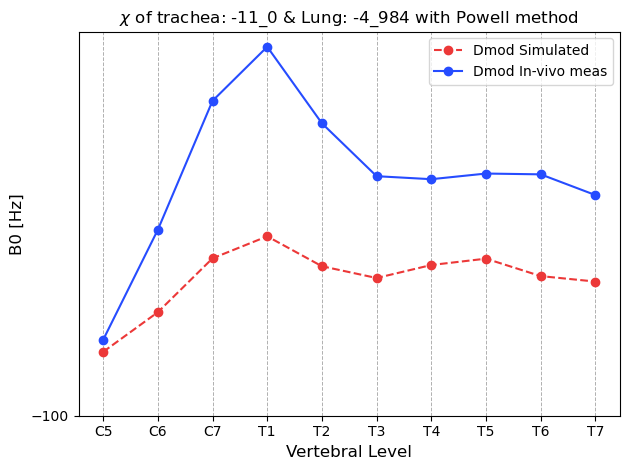

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #39
Chi for trachea: -10.999933238356949
Chi for lungs: -4.990019230627402
For iteration #39 using -376.40247712598415
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_99_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_99_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_99_Hz.csv

Total runtime; 9.831 seconds.

Difference:  249.32551745738806


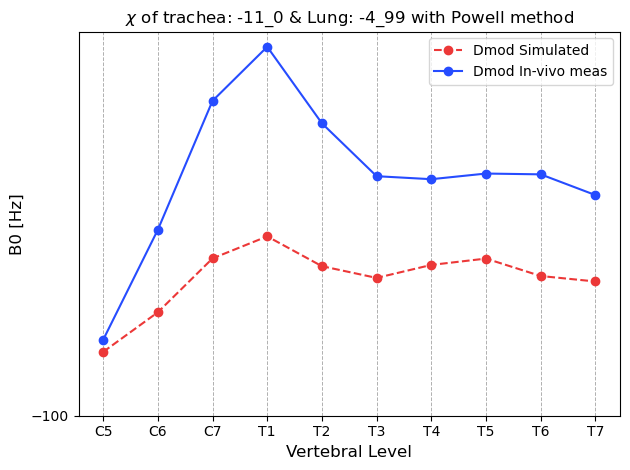

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #40
Chi for trachea: -10.999933238356949
Chi for lungs: -4.99383154529386
For iteration #40 using -376.40325033862496
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_994_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_994_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_994_Hz.csv

Total runtime; 9.883 seconds.

Difference:  249.30099611748687


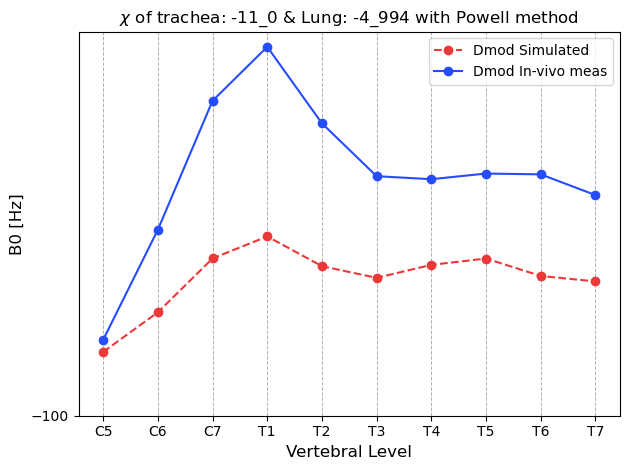

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #41
Chi for trachea: -10.999933238356949
Chi for lungs: -4.996187685333542
For iteration #41 using -376.4037282103175
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_996_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_996_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_996_Hz.csv

Total runtime; 12.493 seconds.

Difference:  249.2858582090922


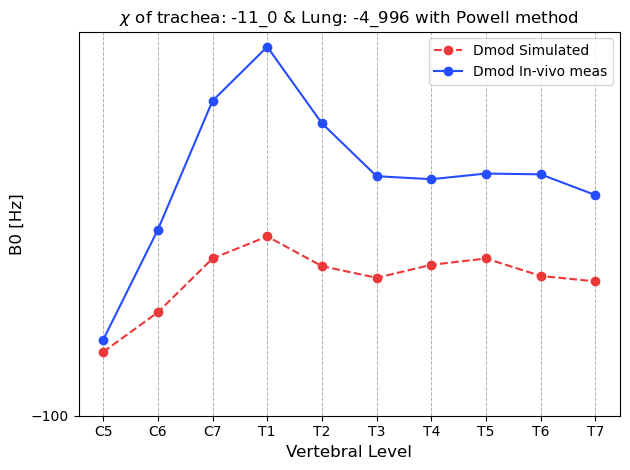

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #42
Chi for trachea: -10.999933238356949
Chi for lungs: -4.997643859960319
For iteration #42 using -376.4040235512658
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_998_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_998_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_998_Hz.csv

Total runtime; 12.437 seconds.

Difference:  249.27650900509843


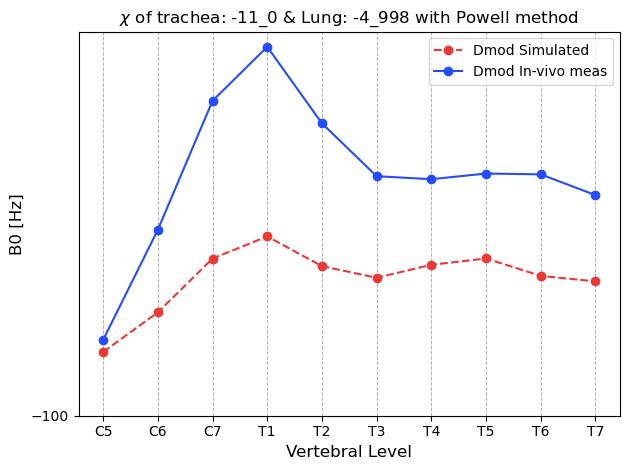

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #43
Chi for trachea: -10.999933238356949
Chi for lungs: -4.998543825373223
For iteration #43 using -376.40420608201015
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_999_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_999_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_999_Hz.csv

Total runtime; 9.830 seconds.

Difference:  249.27073337682603


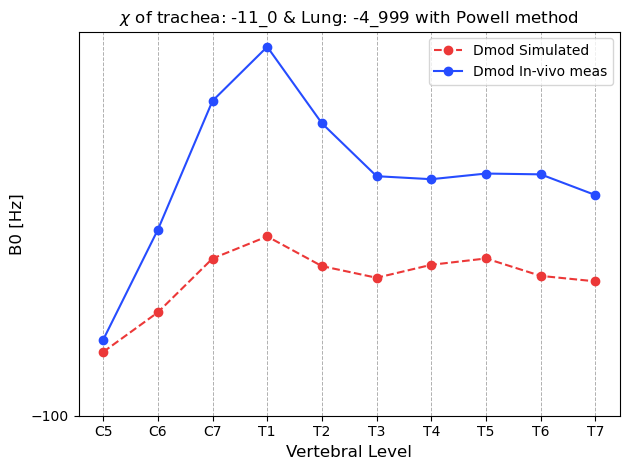

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #44
Chi for trachea: -10.999933238356949
Chi for lungs: -4.999100034587096
For iteration #44 using -376.4043188922141
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_999_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_999_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_999_Hz.csv

Total runtime; 9.766 seconds.

Difference:  249.26716479630335


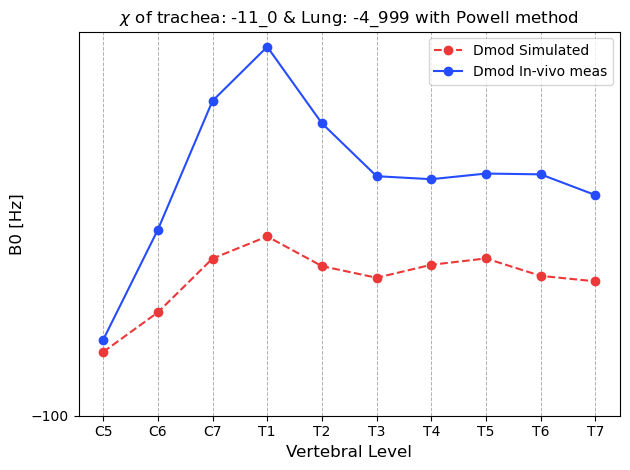

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #45
Chi for trachea: -10.999933238356949
Chi for lungs: -4.999443790786126
For iteration #45 using -376.40438861275436
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-4_999_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_999_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-4_999_Hz.csv

Total runtime; 9.825 seconds.

Difference:  249.26495965668272


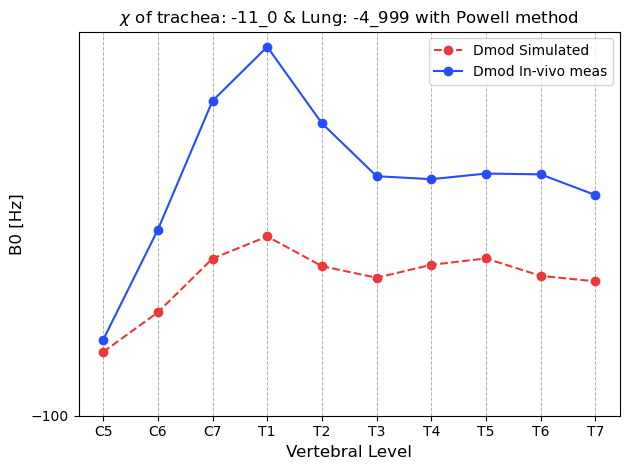

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #46
Chi for trachea: -10.999933238356949
Chi for lungs: -4.99965624380097
For iteration #46 using -376.40443170241804
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 9.820 seconds.

Difference:  249.26359694465242


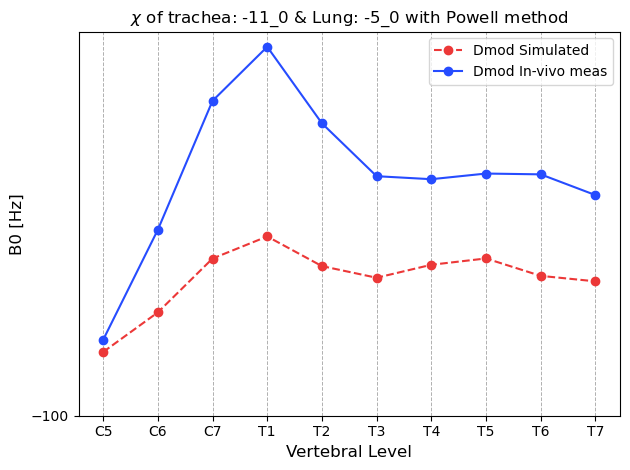

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #47
Chi for trachea: -10.999933238356949
Chi for lungs: -4.999787546985156
For iteration #47 using -376.40445833329477
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 9.654 seconds.

Difference:  249.26275479547334


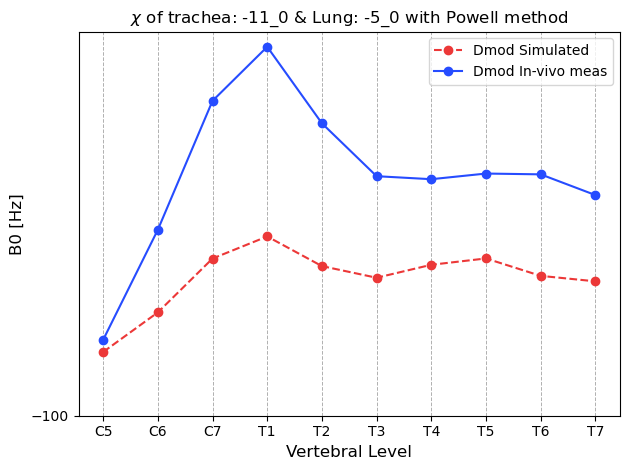

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #48
Chi for trachea: -10.999933238356949
Chi for lungs: -4.999868696815814
For iteration #48 using -376.4044747920817
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 9.729 seconds.

Difference:  249.26223433896752


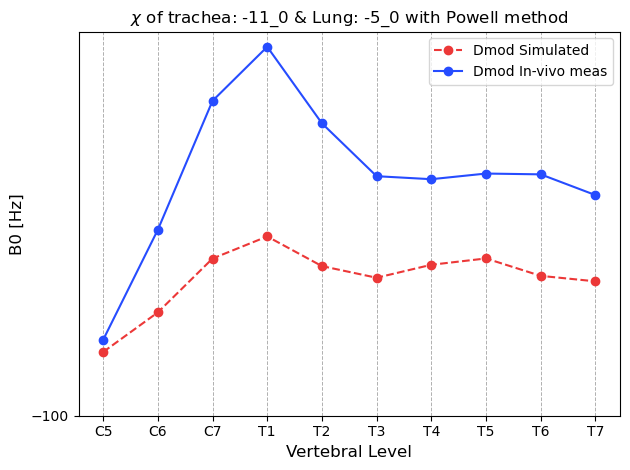

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #49
Chi for trachea: -10.999933238356949
Chi for lungs: -4.999918850169342
For iteration #49 using -376.40448496417144
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 9.770 seconds.

Difference:  249.26191268691522


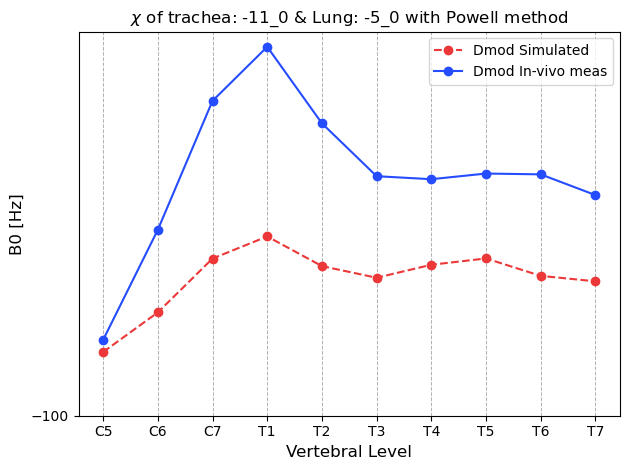

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #50
Chi for trachea: -10.999933238356949
Chi for lungs: -4.999952195367389
For iteration #50 using -376.40449172723555
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 9.760 seconds.

Difference:  249.2616988350764


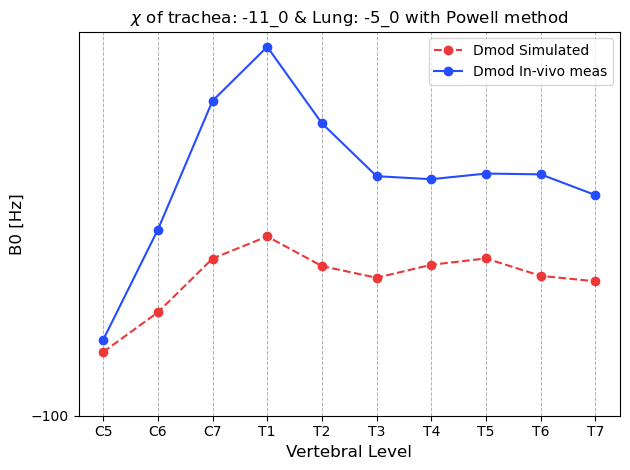

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #51
Chi for trachea: -11.0
Chi for lungs: -4.999958129425067
For iteration #51 using -376.4044928040116
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 9.799 seconds.

Difference:  249.2616373227068


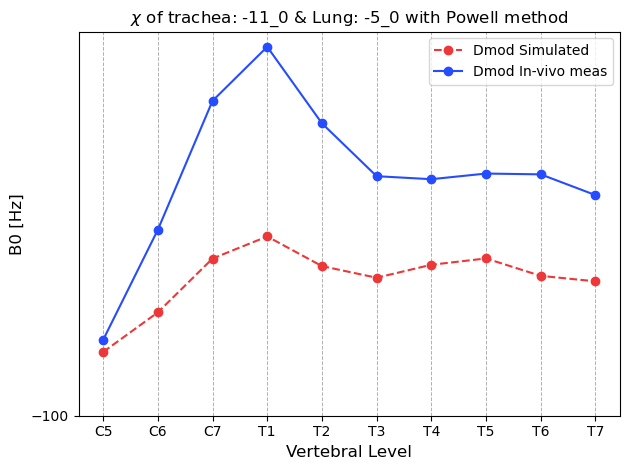

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #52
Chi for trachea: -4.078019326001177
Chi for lungs: -4.384703161437449
For iteration #52 using -376.2928505062942
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-4_078_l_-4_385_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-4_078_l_-4_385_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-4_078_l_-4_385_Hz.csv

Total runtime; 9.884 seconds.

Difference:  256.6129101687663


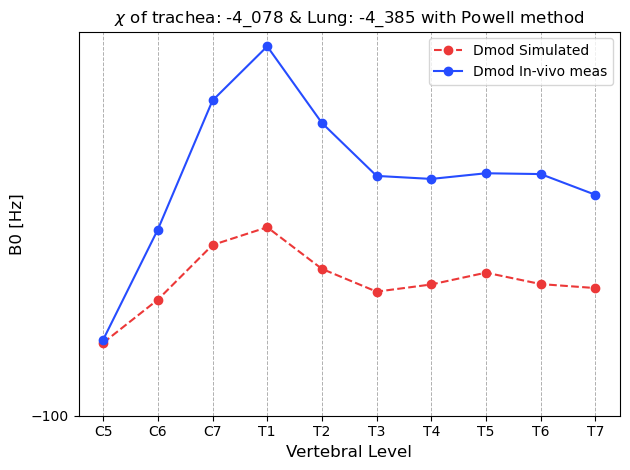

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #53
Chi for trachea: -6.721980673998821
Chi for lungs: -4.61970964746149
For iteration #53 using -376.33549406944013
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-6_722_l_-4_62_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-6_722_l_-4_62_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-6_722_l_-4_62_Hz.csv

Total runtime; 9.772 seconds.

Difference:  253.57916180406687


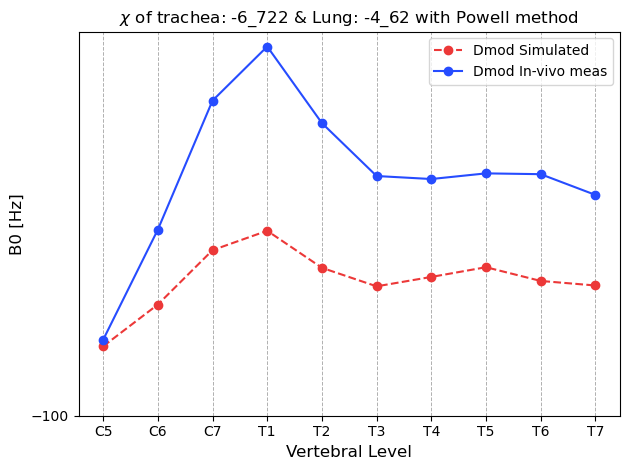

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #54
Chi for trachea: -8.356038652002354
Chi for lungs: -4.764951643401025
For iteration #54 using -376.3618492408657
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-8_356_l_-4_765_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-8_356_l_-4_765_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-8_356_l_-4_765_Hz.csv

Total runtime; 9.940 seconds.

Difference:  251.84220566550093


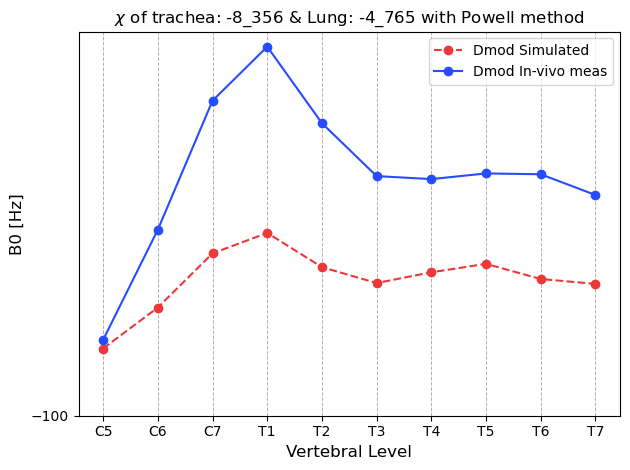

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #55
Chi for trachea: -9.365942021996466
Chi for lungs: -4.854716133485532
For iteration #55 using -376.37813763258606
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-9_366_l_-4_855_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_366_l_-4_855_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_366_l_-4_855_Hz.csv

Total runtime; 9.846 seconds.

Difference:  250.82261957961032


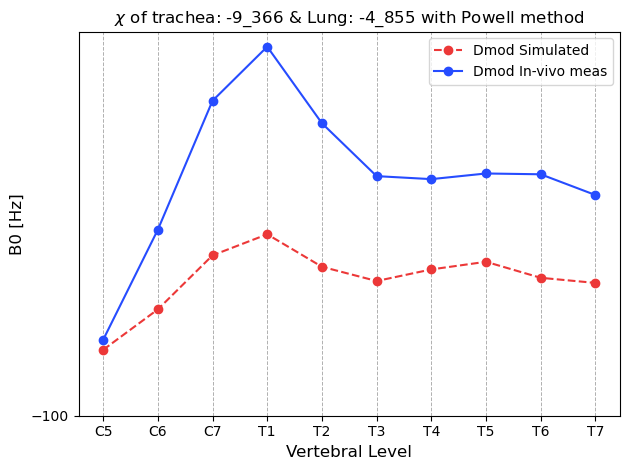

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #56
Chi for trachea: -9.990096630005889
Chi for lungs: -4.91019363934056
For iteration #56 using -376.3882044122913
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-9_99_l_-4_91_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_99_l_-4_91_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_99_l_-4_91_Hz.csv

Total runtime; 9.829 seconds.

Difference:  250.2133475025334


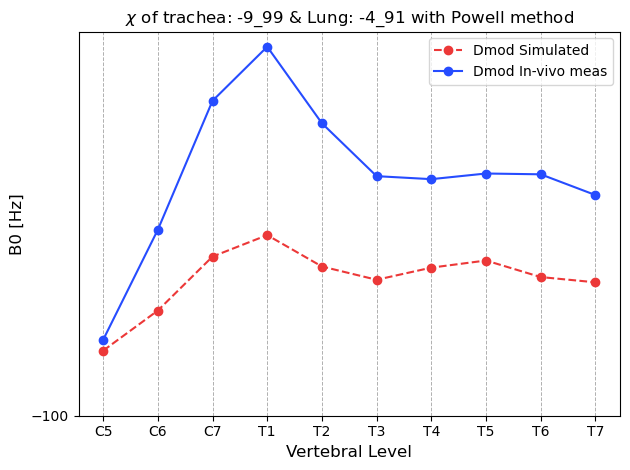

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #57
Chi for trachea: -10.375845391990579
Chi for lungs: -4.944480623570038
For iteration #57 using -376.3944260243064
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_376_l_-4_944_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_376_l_-4_944_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_376_l_-4_944_Hz.csv

Total runtime; 9.863 seconds.

Difference:  249.8448303603255


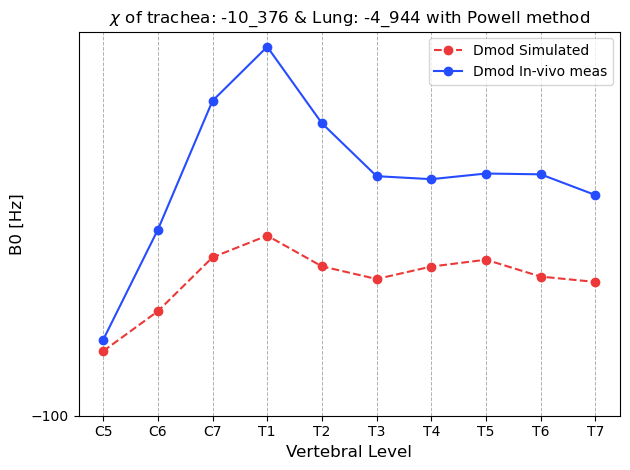

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #58
Chi for trachea: -10.61425123801531
Chi for lungs: -4.9656711451955875
For iteration #58 using -376.3982711919965
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_614_l_-4_966_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_614_l_-4_966_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_614_l_-4_966_Hz.csv

Total runtime; 9.835 seconds.

Difference:  249.62015756622375


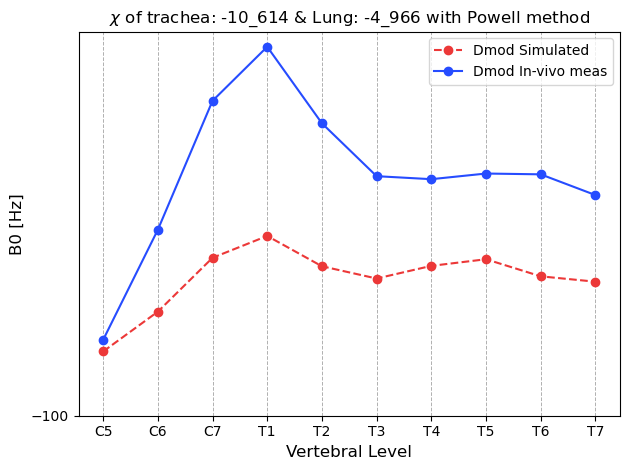

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #59
Chi for trachea: -10.761594153975269
Chi for lungs: -4.978767607799517
For iteration #59 using -376.40064763632154
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_762_l_-4_979_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_762_l_-4_979_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_762_l_-4_979_Hz.csv

Total runtime; 9.820 seconds.

Difference:  249.48248330974903


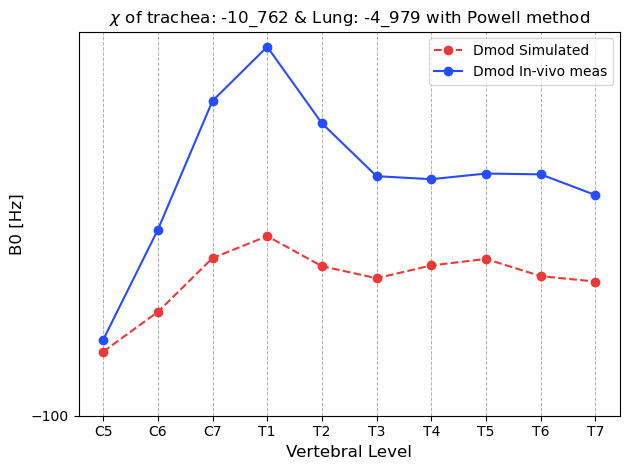

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #60
Chi for trachea: -10.852657084040041
Chi for lungs: -4.986861666821137
For iteration #60 using -376.40211635968666
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_853_l_-4_987_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_853_l_-4_987_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_853_l_-4_987_Hz.csv

Total runtime; 9.867 seconds.

Difference:  249.397847912658


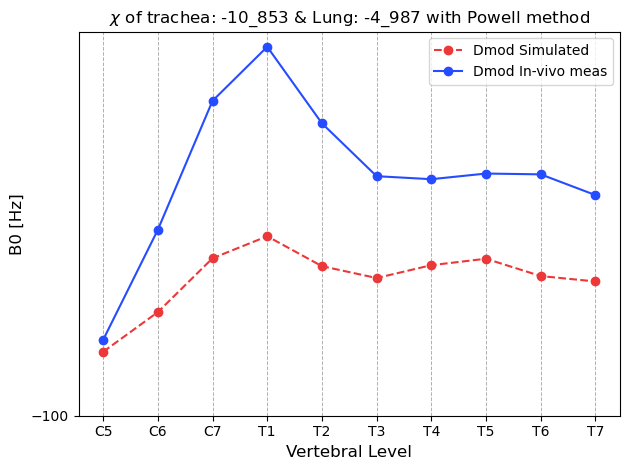

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #61
Chi for trachea: -10.908937069935227
Chi for lungs: -4.991864070403446
For iteration #61 using -376.40302408064645
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_909_l_-4_992_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_909_l_-4_992_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_909_l_-4_992_Hz.csv

Total runtime; 9.968 seconds.

Difference:  249.34571318866895


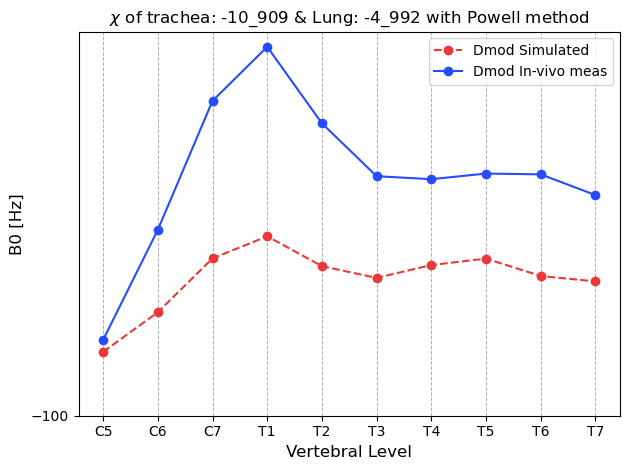

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #62
Chi for trachea: -10.943720014104816
Chi for lungs: -4.9949557258427575
For iteration #62 using -376.4035850830519
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_944_l_-4_995_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_944_l_-4_995_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_944_l_-4_995_Hz.csv

Total runtime; 9.902 seconds.

Difference:  249.31355821639679


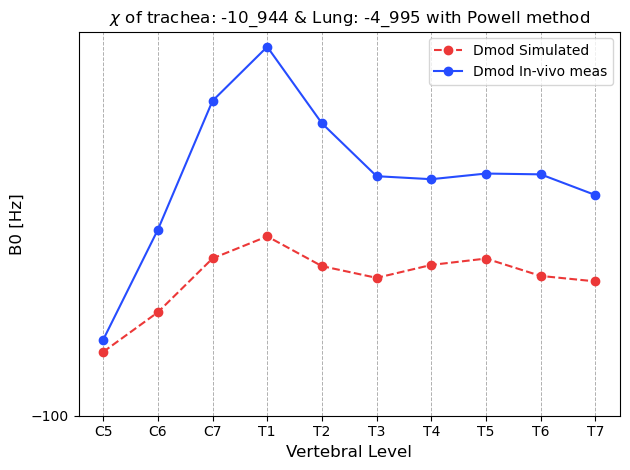

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #63
Chi for trachea: -10.965217055830411
Chi for lungs: -4.996866473985755
For iteration #63 using -376.4039318016062
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_965_l_-4_997_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_965_l_-4_997_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_965_l_-4_997_Hz.csv

Total runtime; 13.179 seconds.

Difference:  249.2937105935104


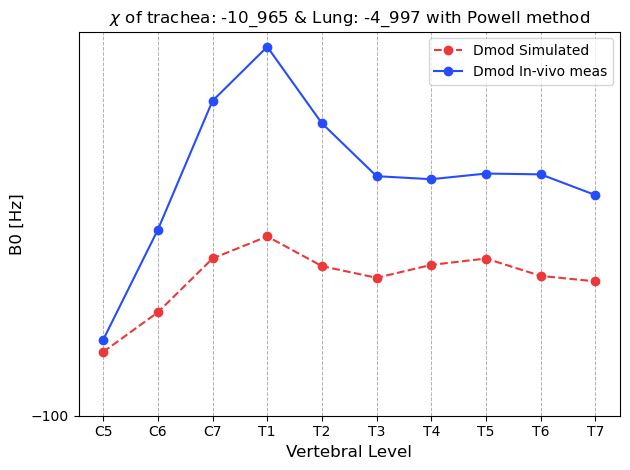

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #64
Chi for trachea: -10.978502958274404
Chi for lungs: -4.998047381282069
For iteration #64 using -376.40414608545734
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_979_l_-4_998_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_979_l_-4_998_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_979_l_-4_998_Hz.csv

Total runtime; 12.842 seconds.

Difference:  249.28145373237956


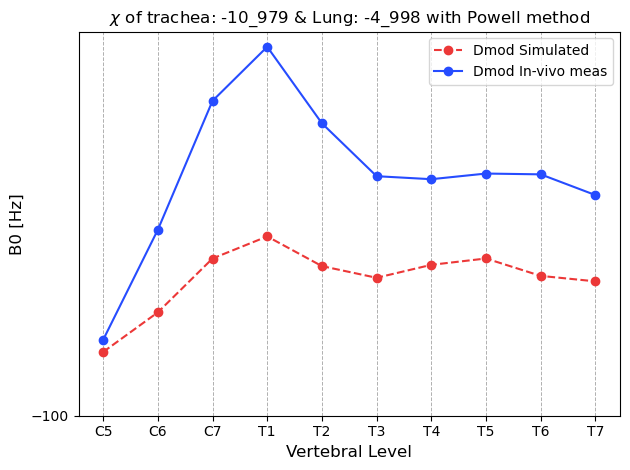

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #65
Chi for trachea: -10.986714097556007
Chi for lungs: -4.998777222128753
For iteration #65 using -376.4042785201605
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_987_l_-4_999_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_987_l_-4_999_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_987_l_-4_999_Hz.csv

Total runtime; 13.006 seconds.

Difference:  249.2738822600281


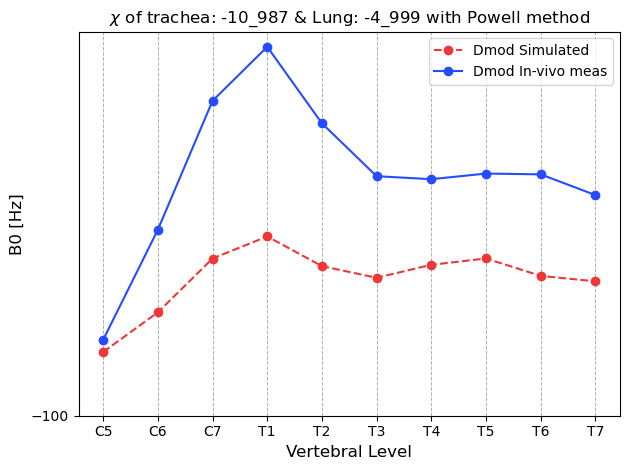

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #66
Chi for trachea: -10.991788860718398
Chi for lungs: -4.999228288578382
For iteration #66 using -376.4043603693084
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_992_l_-4_999_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_992_l_-4_999_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_992_l_-4_999_Hz.csv

Total runtime; 17.302 seconds.

Difference:  249.26920424023263


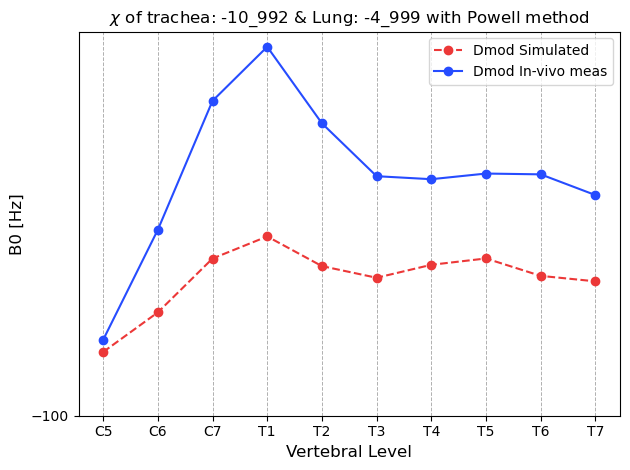

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #67
Chi for trachea: -10.99492523683761
Chi for lungs: -4.999507062975438
For iteration #67 using -376.4044109548638
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_995_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_995_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_995_l_-5_0_Hz.csv

Total runtime; 10.290 seconds.

Difference:  249.26631360263437


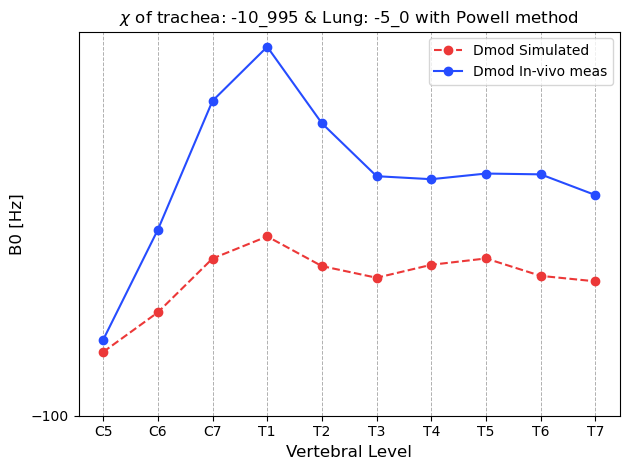

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #68
Chi for trachea: -10.996863623880786
Chi for lungs: -4.999679355028011
For iteration #68 using -376.40444221845627
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_997_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_997_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_997_l_-5_0_Hz.csv

Total runtime; 9.893 seconds.

Difference:  249.26452729571588


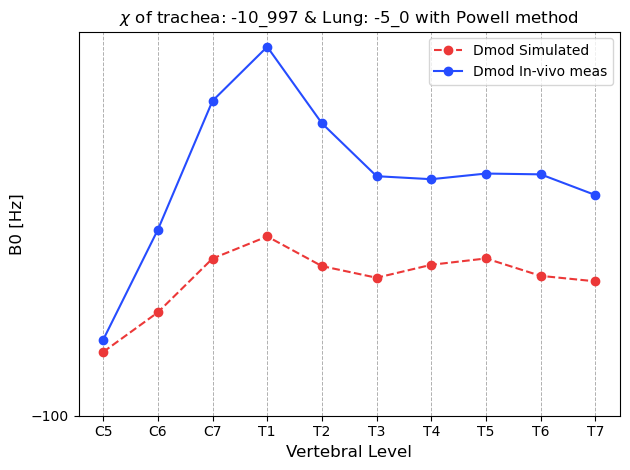

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #69
Chi for trachea: -10.998061612956823
Chi for lungs: -4.999785837372492
For iteration #69 using -376.40446154041905
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_998_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_998_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_998_l_-5_0_Hz.csv

Total runtime; 9.731 seconds.

Difference:  249.2634233757706


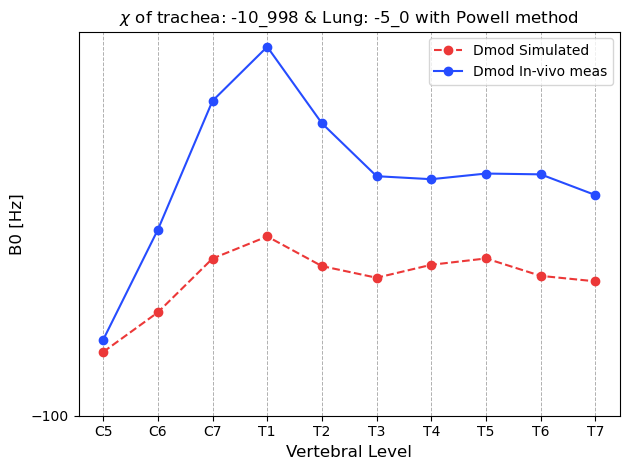

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #70
Chi for trachea: -10.998802010923963
Chi for lungs: -4.999851647080584
For iteration #70 using -376.40447348204884
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_999_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-5_0_Hz.csv

Total runtime; 9.847 seconds.

Difference:  249.26274114568716


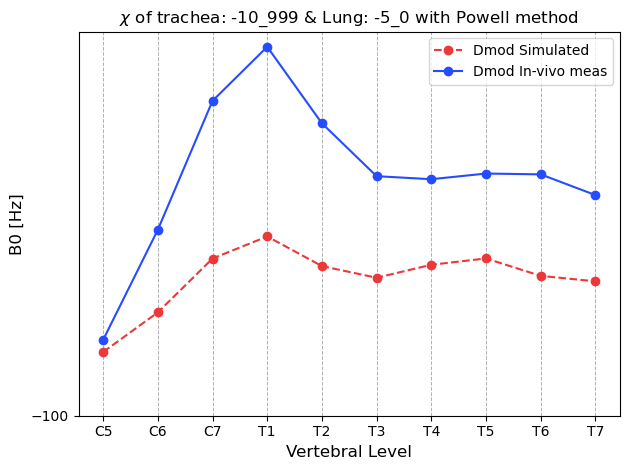

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #71
Chi for trachea: -10.99925960203286
Chi for lungs: -4.999892319716975
For iteration #71 using -376.4044808623819
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_999_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-5_0_Hz.csv

Total runtime; 12.495 seconds.

Difference:  249.26231951575255


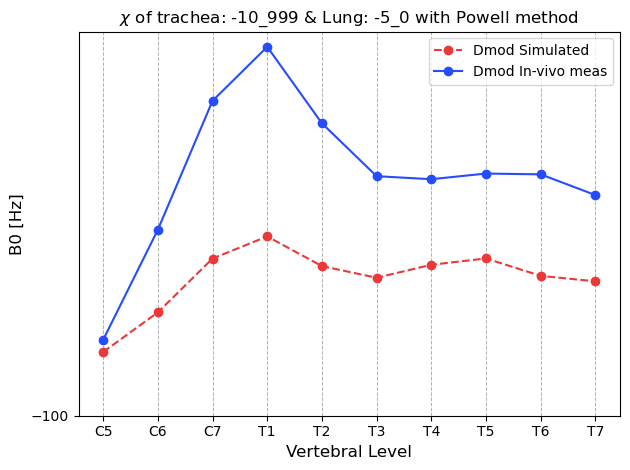

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #72
Chi for trachea: -10.999559599817463
Chi for lungs: -4.999918984791042
For iteration #72 using -376.4044857009453
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.738 seconds.

Difference:  249.2620430989417


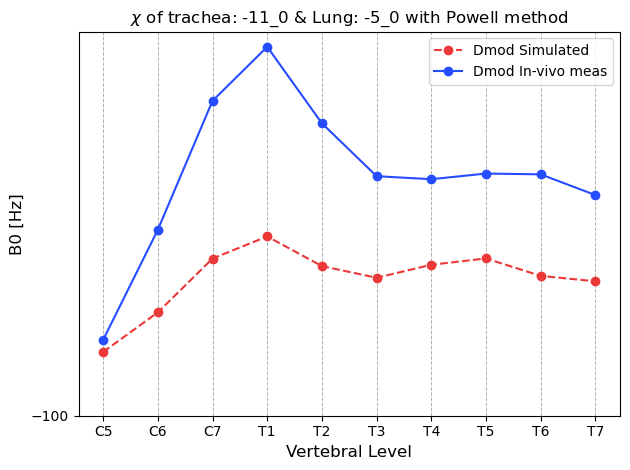

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #73
Chi for trachea: -6.721980673998823
Chi for lungs: -4.999918984791042
For iteration #73 using -376.4126080255277
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-6_722_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-6_722_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-6_722_l_-5_0_Hz.csv

Total runtime; 12.242 seconds.

Difference:  250.83730750401736


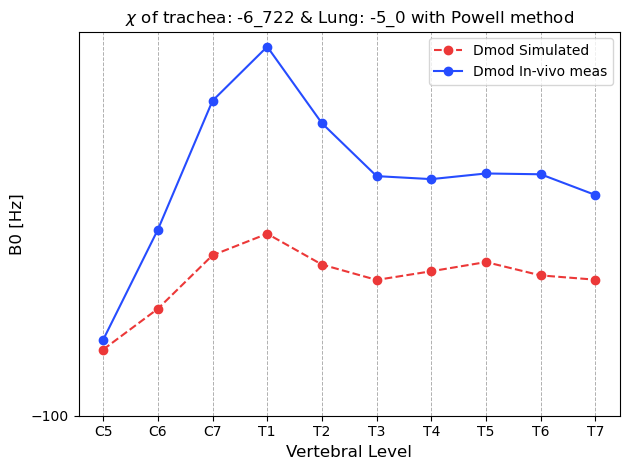

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #74
Chi for trachea: -4.078019326001179
Chi for lungs: -4.999918984791042
For iteration #74 using -376.4176284150107
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-4_078_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-4_078_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-4_078_l_-5_0_Hz.csv

Total runtime; 12.807 seconds.

Difference:  251.8826015857392


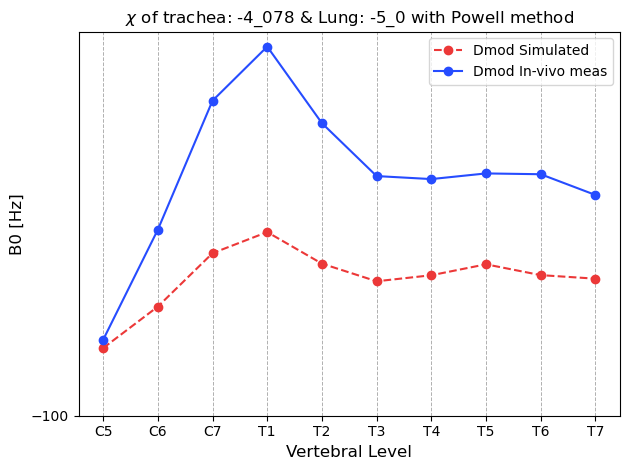

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #75
Chi for trachea: -8.356038652002356
Chi for lungs: -4.999918984791042
For iteration #75 using -376.4095052541905
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-8_356_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-8_356_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-8_356_l_-5_0_Hz.csv

Total runtime; 13.082 seconds.

Difference:  250.21853157545544


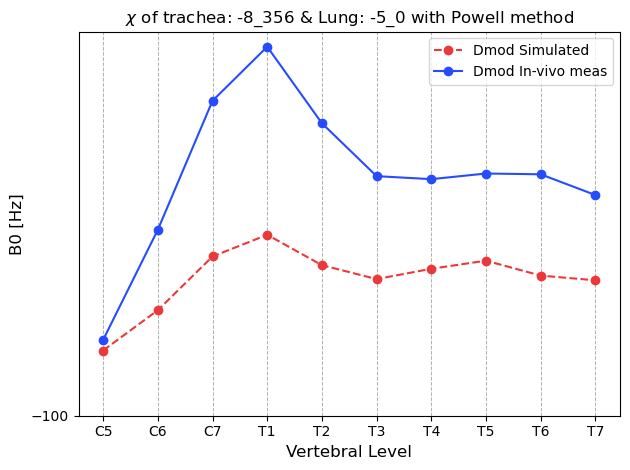

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #76
Chi for trachea: -9.365942021996467
Chi for lungs: -4.999918984791042
For iteration #76 using -376.4075876360447
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-9_366_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_366_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_366_l_-5_0_Hz.csv

Total runtime; 12.956 seconds.

Difference:  249.84660023220115


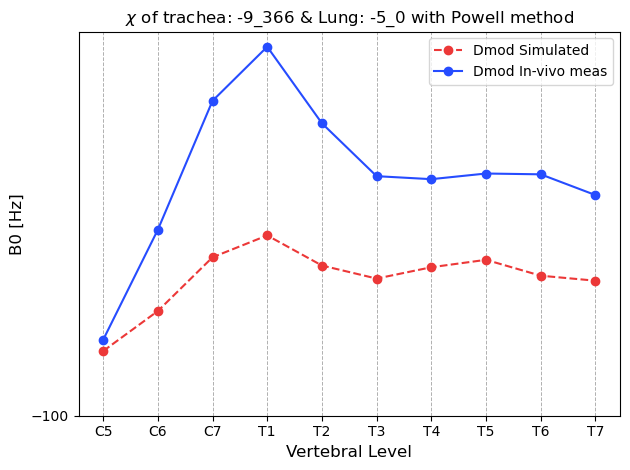

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #77
Chi for trachea: -9.990096630005889
Chi for lungs: -4.999918984791042
For iteration #77 using -376.4064024828532
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-9_99_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_99_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_99_l_-5_0_Hz.csv

Total runtime; 12.542 seconds.

Difference:  249.62076150065326


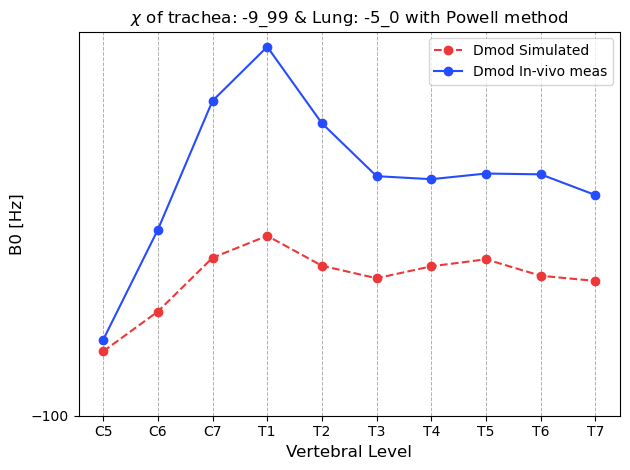

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #78
Chi for trachea: -10.375845391990579
Chi for lungs: -4.999918984791042
For iteration #78 using -376.40567001789896
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_376_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_376_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_376_l_-5_0_Hz.csv

Total runtime; 12.835 seconds.

Difference:  249.48272837086571


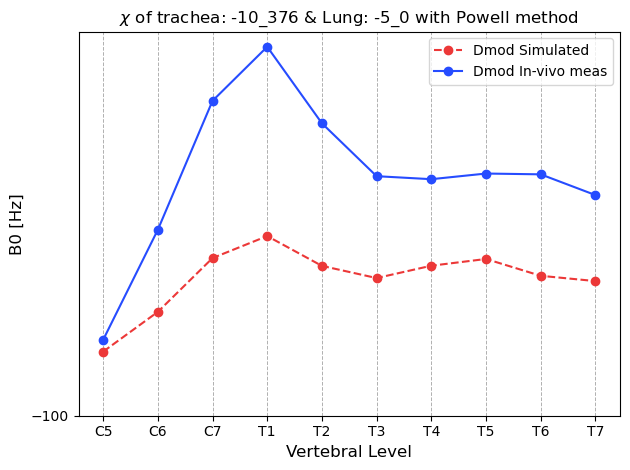

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #79
Chi for trachea: -10.61425123801531
Chi for lungs: -4.999918984791042
For iteration #79 using -376.40521732966164
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_614_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_614_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_614_l_-5_0_Hz.csv

Total runtime; 12.866 seconds.

Difference:  249.39800959144665


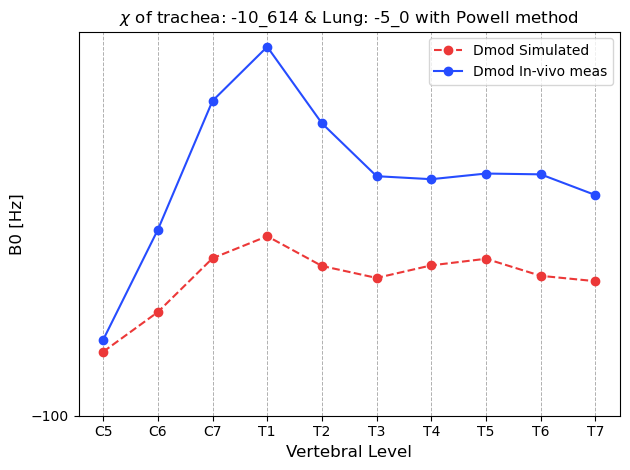

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #80
Chi for trachea: -10.761594153975269
Chi for lungs: -4.999918984791042
For iteration #80 using -376.4049375529448
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_762_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_762_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_762_l_-5_0_Hz.csv

Total runtime; 13.194 seconds.

Difference:  249.34587626207994


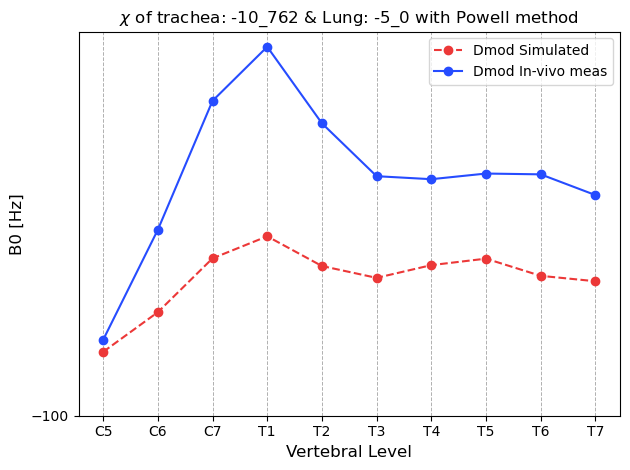

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #81
Chi for trachea: -10.852657084040041
Chi for lungs: -4.999918984791042
For iteration #81 using -376.4047646414243
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_853_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_853_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_853_l_-5_0_Hz.csv

Total runtime; 13.242 seconds.

Difference:  249.3137423820267


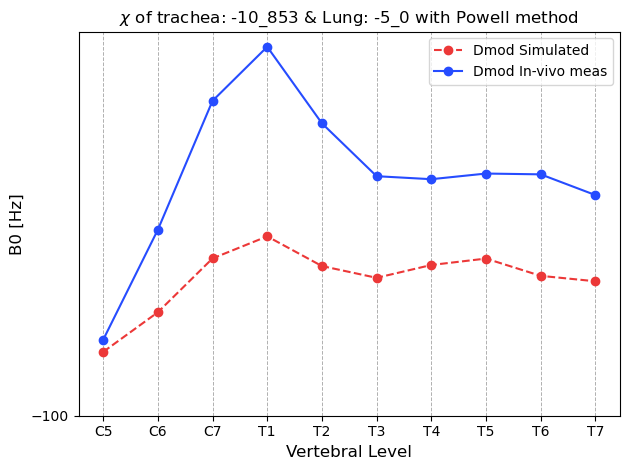

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #82
Chi for trachea: -10.908937069935227
Chi for lungs: -4.999918984791042
For iteration #82 using -376.4046577762278
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_909_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_909_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_909_l_-5_0_Hz.csv

Total runtime; 12.775 seconds.

Difference:  249.2939155253525


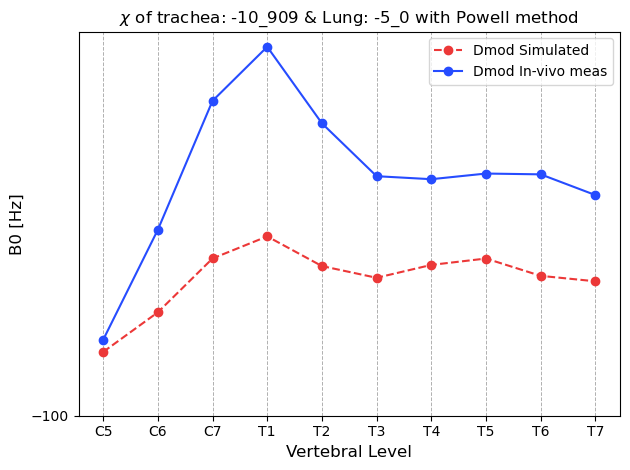

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #83
Chi for trachea: -10.943720014104816
Chi for lungs: -4.999918984791042
For iteration #83 using -376.4045917299041
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_944_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_944_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_944_l_-5_0_Hz.csv

Total runtime; 12.434 seconds.

Difference:  249.28167445199452


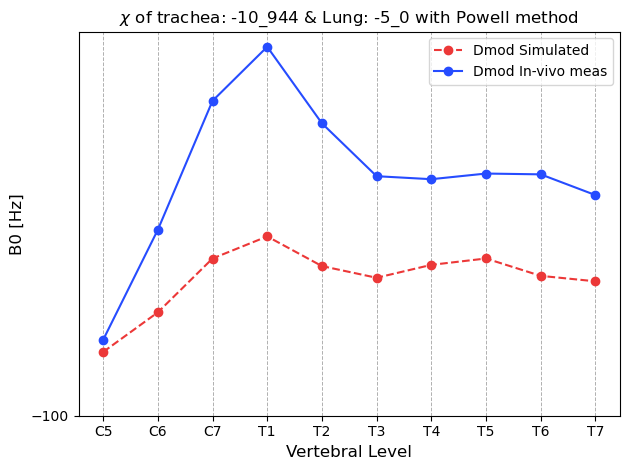

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #84
Chi for trachea: -10.965217055830411
Chi for lungs: -4.999918984791042
For iteration #84 using -376.4045509110312
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_965_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_965_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_965_l_-5_0_Hz.csv

Total runtime; 12.728 seconds.

Difference:  249.2741138653567


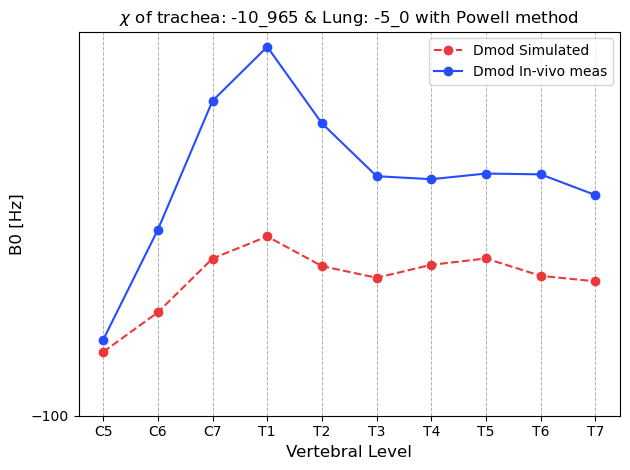

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #85
Chi for trachea: -10.978502958274404
Chi for lungs: -4.999918984791042
For iteration #85 using -376.40452568358035
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_979_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_979_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_979_l_-5_0_Hz.csv

Total runtime; 12.461 seconds.

Difference:  249.26944300432945


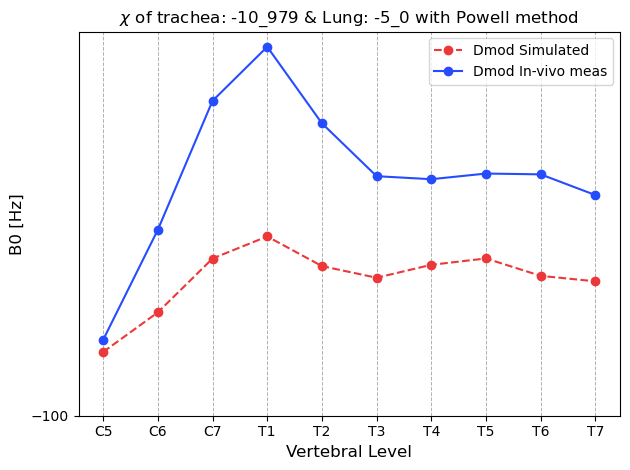

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #86
Chi for trachea: -10.986714097556007
Chi for lungs: -4.999918984791042
For iteration #86 using -376.4045100921583
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_987_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_987_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_987_l_-5_0_Hz.csv

Total runtime; 12.435 seconds.

Difference:  249.26655695574084


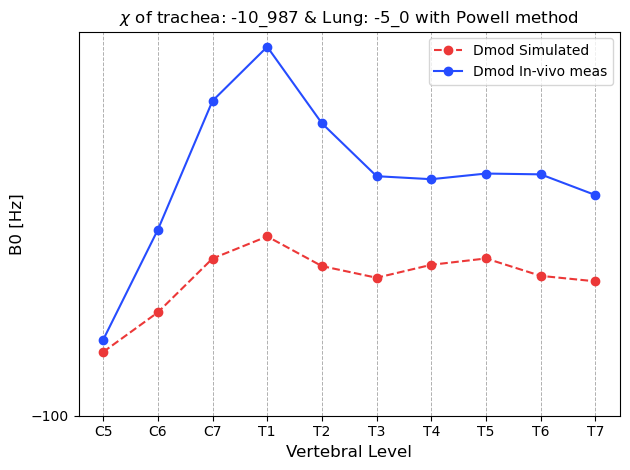

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #87
Chi for trachea: -10.991788860718398
Chi for lungs: -4.999918984791042
For iteration #87 using -376.4045004561294
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_992_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_992_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_992_l_-5_0_Hz.csv

Total runtime; 12.575 seconds.

Difference:  249.26477354787846


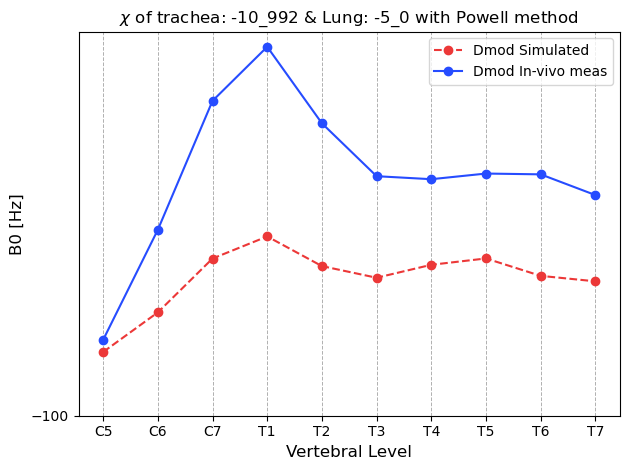

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #88
Chi for trachea: -10.99492523683761
Chi for lungs: -4.999918984791042
For iteration #88 using -376.40449450073623
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_995_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_995_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_995_l_-5_0_Hz.csv

Total runtime; 12.766 seconds.

Difference:  249.26367144367163


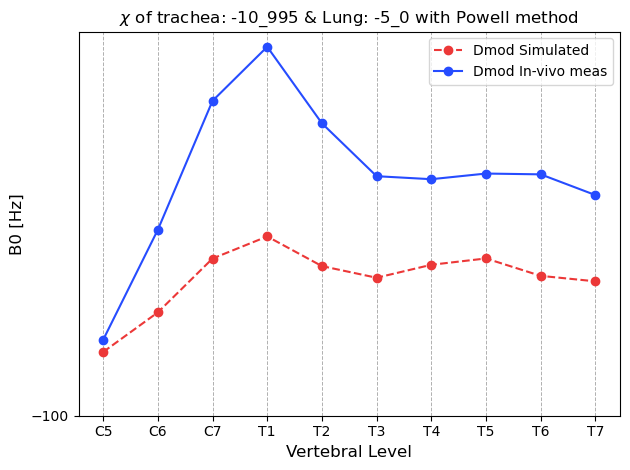

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #89
Chi for trachea: -10.996863623880786
Chi for lungs: -4.999918984791042
For iteration #89 using -376.40449082010076
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_997_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_997_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_997_l_-5_0_Hz.csv

Total runtime; 12.625 seconds.

Difference:  249.26299034495233


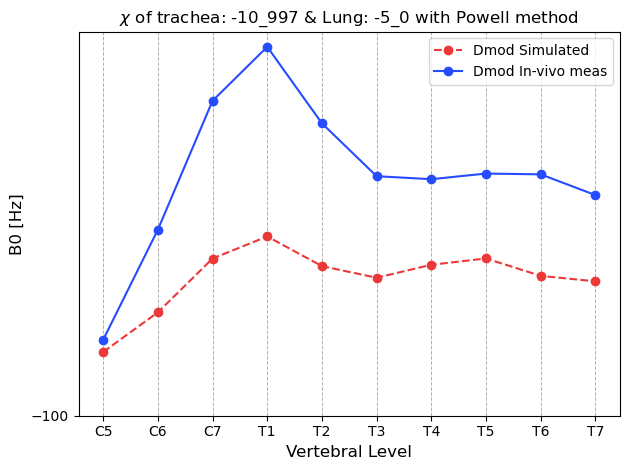

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #90
Chi for trachea: -10.998061612956823
Chi for lungs: -4.999918984791042
For iteration #90 using -376.40448854534293
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_998_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_998_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_998_l_-5_0_Hz.csv

Total runtime; 12.613 seconds.

Difference:  249.2625694177445


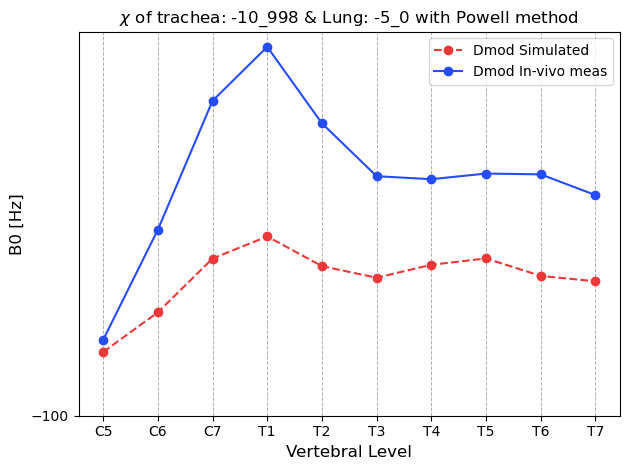

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #91
Chi for trachea: -10.998802010923963
Chi for lungs: -4.999918984791042
For iteration #91 using -376.40448713946523
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_999_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-5_0_Hz.csv

Total runtime; 12.338 seconds.

Difference:  249.26230927613375


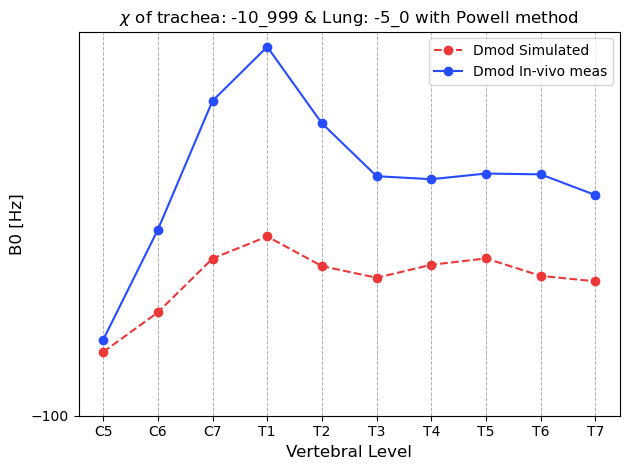

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #92
Chi for trachea: -10.99925960203286
Chi for lungs: -4.999918984791042
For iteration #92 using -376.40448627058504
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_999_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-5_0_Hz.csv

Total runtime; 12.258 seconds.

Difference:  249.26214850195777


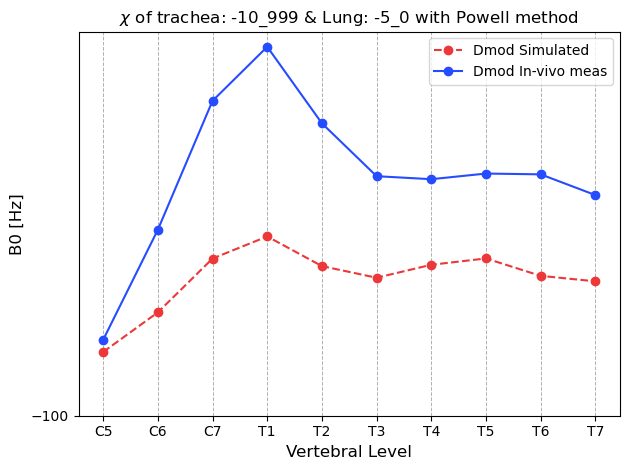

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #93
Chi for trachea: -10.999542408891106
Chi for lungs: -4.999918984791042
For iteration #93 using -376.4044857335876
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.800 seconds.

Difference:  249.2620491388854


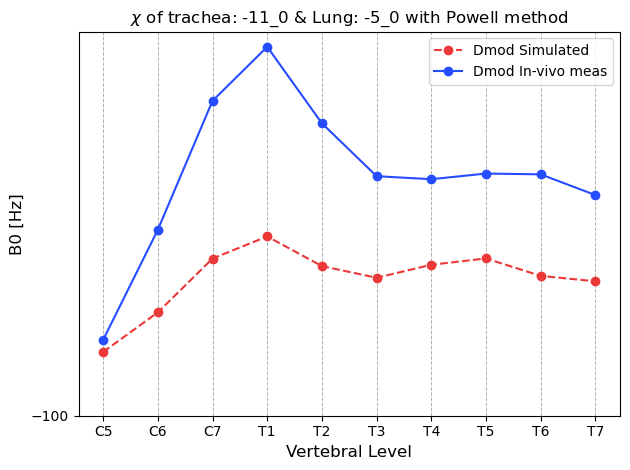

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #94
Chi for trachea: -10.999717193141754
Chi for lungs: -4.999918984791042
For iteration #94 using -376.40448540170496
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.373 seconds.

Difference:  249.26198772944767


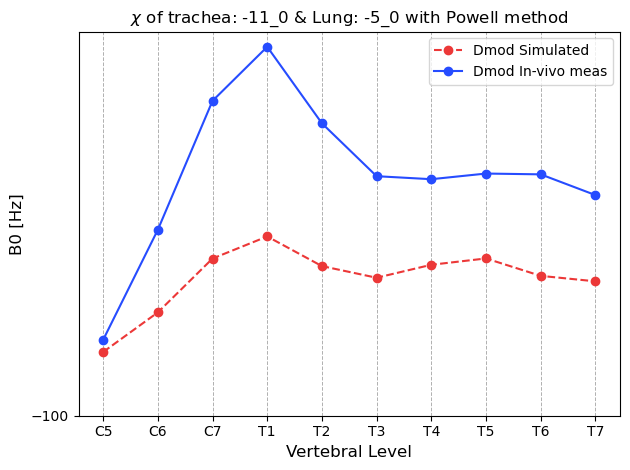

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #95
Chi for trachea: -10.999825215749352
Chi for lungs: -4.999918984791042
For iteration #95 using -376.40448519659014
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 16.564 seconds.

Difference:  249.26194977644963


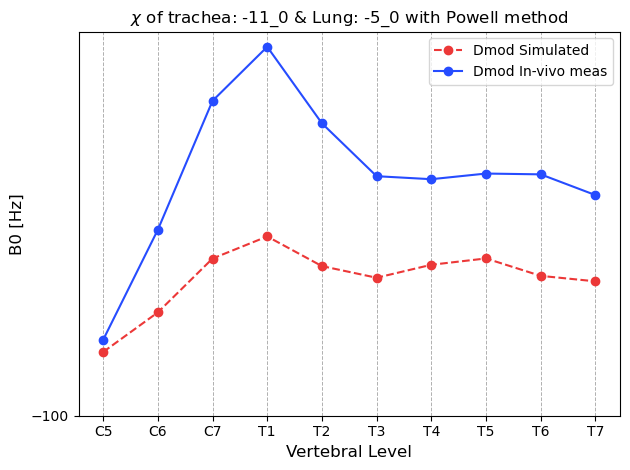

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #96
Chi for trachea: -10.999891977392402
Chi for lungs: -4.999918984791042
For iteration #96 using -376.4044850698223
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.290 seconds.

Difference:  249.26192632025317


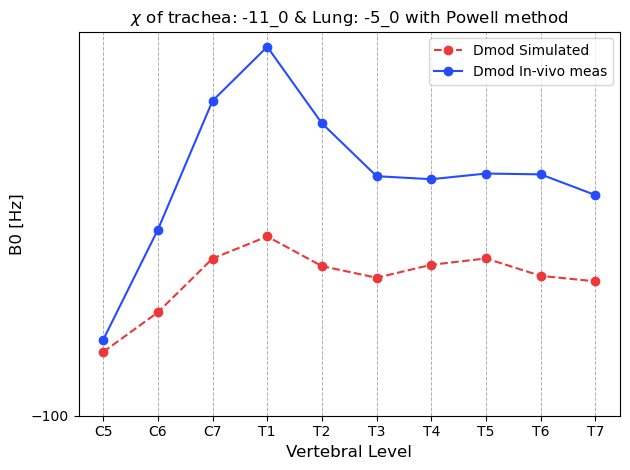

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #97
Chi for trachea: -10.99993323835695
Chi for lungs: -4.999918984791042
For iteration #97 using -376.40448499147533
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 13.078 seconds.

Difference:  249.2619118235443


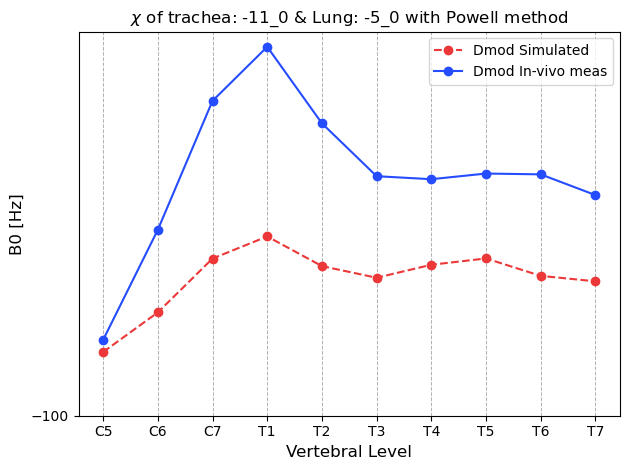

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #98
Chi for trachea: -10.999966571695825
Chi for lungs: -4.999918984791042
For iteration #98 using -376.4044849281816
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.605 seconds.

Difference:  249.261900112153


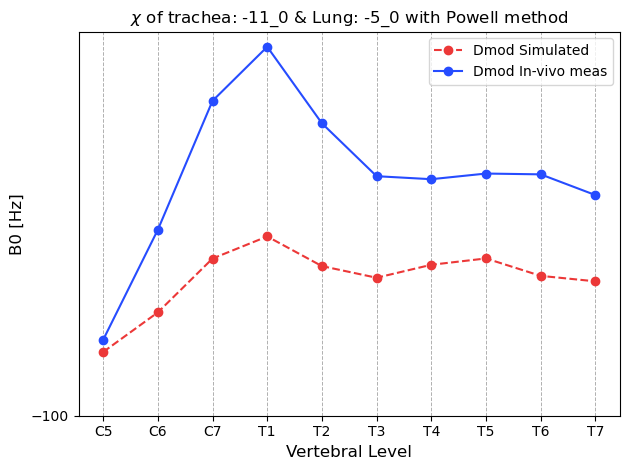

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #99
Chi for trachea: -6.721980673998822
Chi for lungs: -4.619673474076763
For iteration #99 using -376.3354867327639
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-6_722_l_-4_62_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-6_722_l_-4_62_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-6_722_l_-4_62_Hz.csv

Total runtime; 12.247 seconds.

Difference:  253.57943829932034


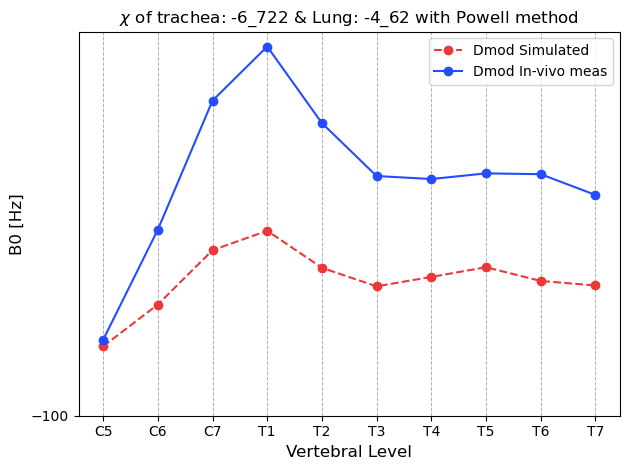

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #100
Chi for trachea: -4.0780193260011774
Chi for lungs: -4.384666988052722
For iteration #100 using -376.292843169618
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-4_078_l_-4_385_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-4_078_l_-4_385_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-4_078_l_-4_385_Hz.csv

Total runtime; 12.330 seconds.

Difference:  256.6132129886228


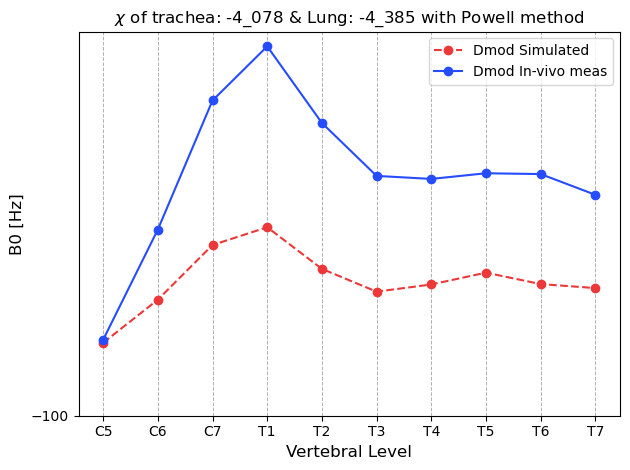

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #101
Chi for trachea: -8.356038652002354
Chi for lungs: -4.764915470016298
For iteration #101 using -376.36184190418953
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-8_356_l_-4_765_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-8_356_l_-4_765_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-8_356_l_-4_765_Hz.csv

Total runtime; 12.456 seconds.

Difference:  251.8424654315444


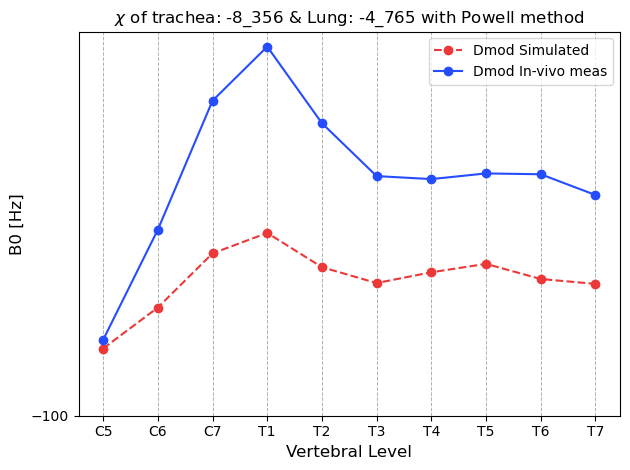

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #102
Chi for trachea: -9.365942021996467
Chi for lungs: -4.854679960100804
For iteration #102 using -376.3781302959099
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-9_366_l_-4_855_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_366_l_-4_855_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_366_l_-4_855_Hz.csv

Total runtime; 17.145 seconds.

Difference:  250.822868836971


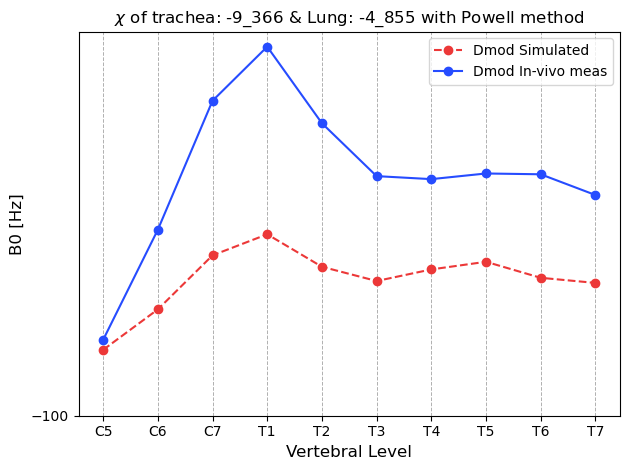

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #103
Chi for trachea: -9.990096630005889
Chi for lungs: -4.910157465955833
For iteration #103 using -376.38819707561515
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-9_99_l_-4_91_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_99_l_-4_91_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-9_99_l_-4_91_Hz.csv

Total runtime; 12.631 seconds.

Difference:  250.2135902021038


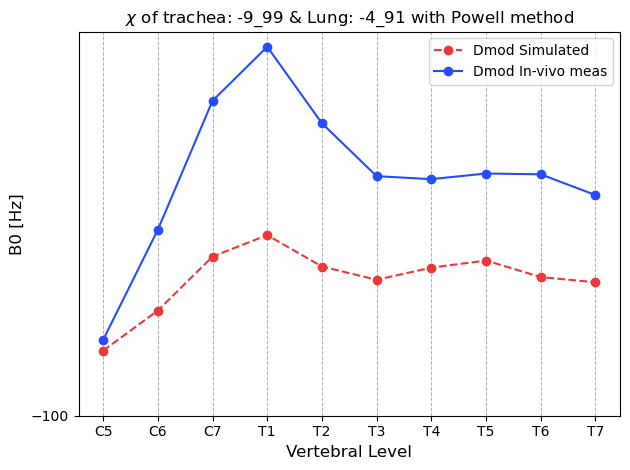

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #104
Chi for trachea: -10.375845391990579
Chi for lungs: -4.944444450185311
For iteration #104 using -376.3944186876302
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_376_l_-4_944_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_376_l_-4_944_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_376_l_-4_944_Hz.csv

Total runtime; 12.276 seconds.

Difference:  249.84506898329317


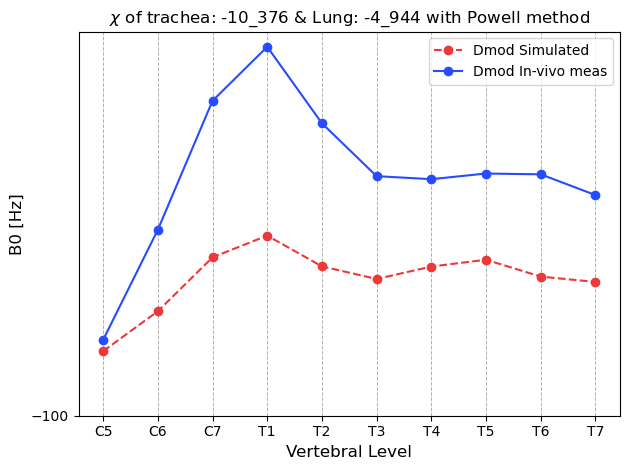

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #105
Chi for trachea: -10.61425123801531
Chi for lungs: -4.965634971810861
For iteration #105 using -376.39826385532035
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_614_l_-4_966_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_614_l_-4_966_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_614_l_-4_966_Hz.csv

Total runtime; 12.515 seconds.

Difference:  249.62039366077744


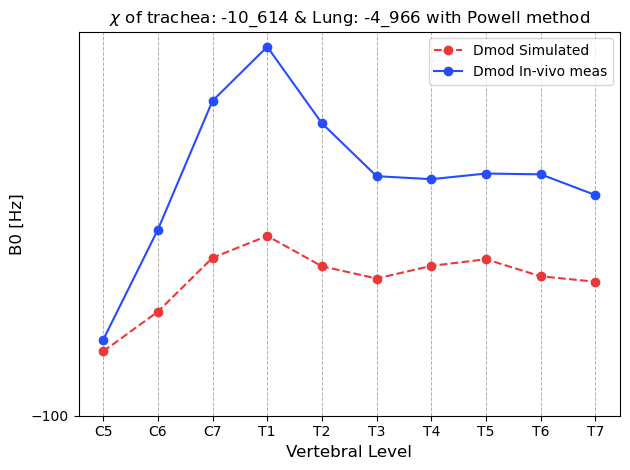

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #106
Chi for trachea: -10.761594153975269
Chi for lungs: -4.97873143441479
For iteration #106 using -376.4006402996453
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_762_l_-4_979_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_762_l_-4_979_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_762_l_-4_979_Hz.csv

Total runtime; 10.018 seconds.

Difference:  249.48271783826976


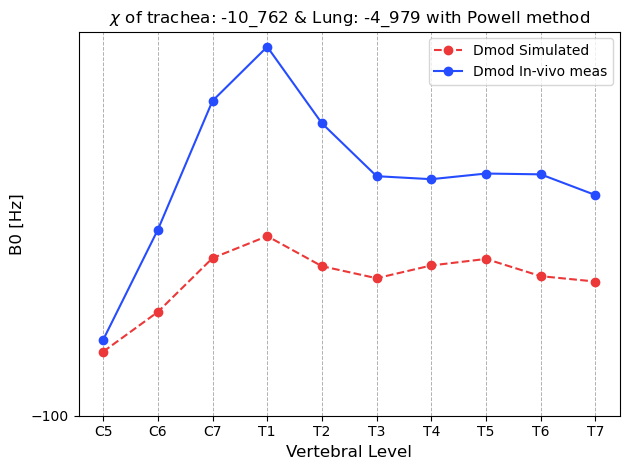

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #107
Chi for trachea: -10.852657084040041
Chi for lungs: -4.98682549343641
For iteration #107 using -376.4021090230105
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_853_l_-4_987_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_853_l_-4_987_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_853_l_-4_987_Hz.csv

Total runtime; 9.729 seconds.

Difference:  249.39808147202928


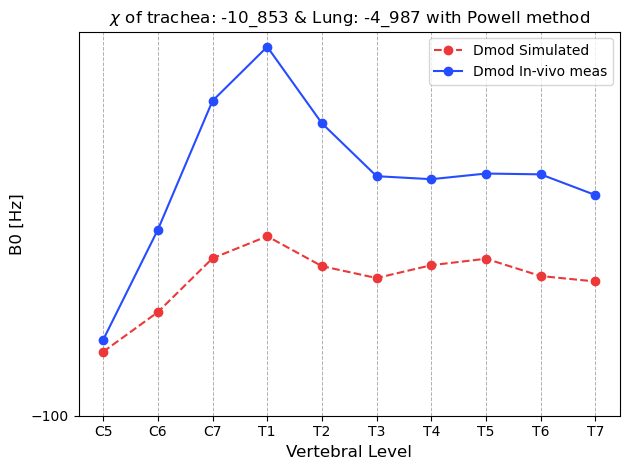

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #108
Chi for trachea: -10.908937069935227
Chi for lungs: -4.991827897018719
For iteration #108 using -376.4030167439702
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_909_l_-4_992_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_909_l_-4_992_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_909_l_-4_992_Hz.csv

Total runtime; 9.897 seconds.

Difference:  249.34594614858278


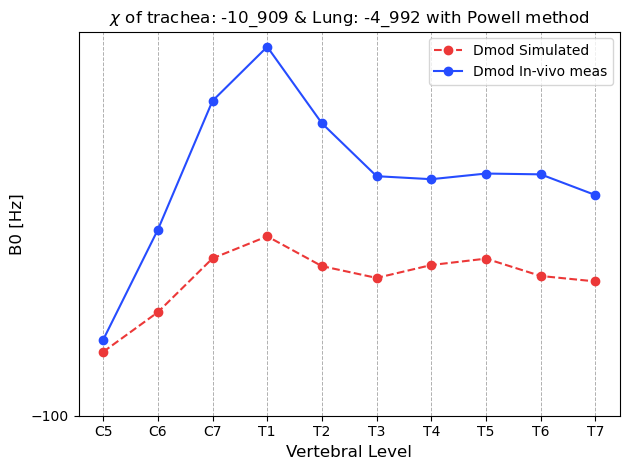

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #109
Chi for trachea: -10.943720014104816
Chi for lungs: -4.99491955245803
For iteration #109 using -376.40357774637573
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_944_l_-4_995_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_944_l_-4_995_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_944_l_-4_995_Hz.csv

Total runtime; 9.861 seconds.

Difference:  249.3137908056381


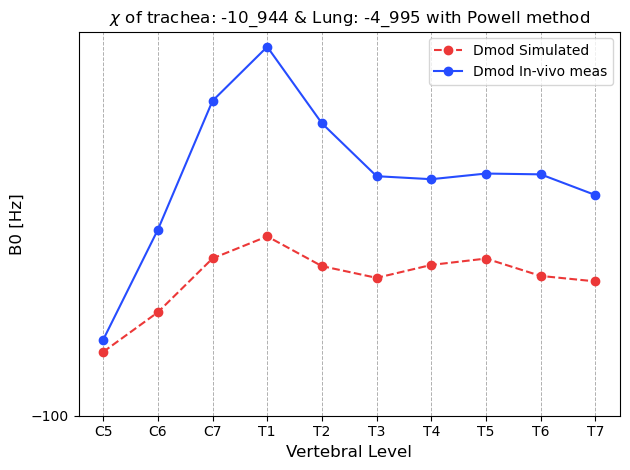

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #110
Chi for trachea: -10.965217055830411
Chi for lungs: -4.996830300601028
For iteration #110 using -376.40392446493007
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_965_l_-4_997_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_965_l_-4_997_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_965_l_-4_997_Hz.csv

Total runtime; 9.954 seconds.

Difference:  249.29394295359216


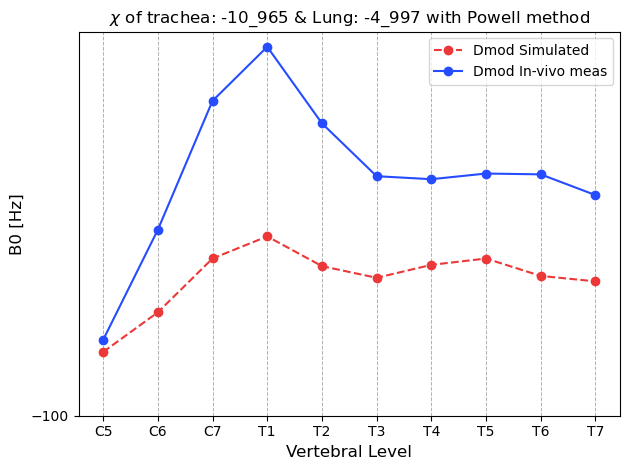

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #111
Chi for trachea: -10.978502958274404
Chi for lungs: -4.998011207897341
For iteration #111 using -376.4041387487811
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_979_l_-4_998_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_979_l_-4_998_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_979_l_-4_998_Hz.csv

Total runtime; 9.903 seconds.

Difference:  249.2816859508061


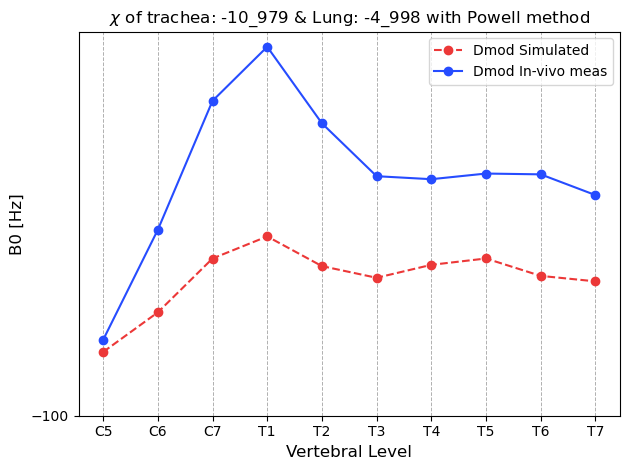

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #112
Chi for trachea: -10.986714097556007
Chi for lungs: -4.998741048744026
For iteration #112 using -376.4042711834843
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_987_l_-4_999_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_987_l_-4_999_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_987_l_-4_999_Hz.csv

Total runtime; 9.896 seconds.

Difference:  249.27411439089624


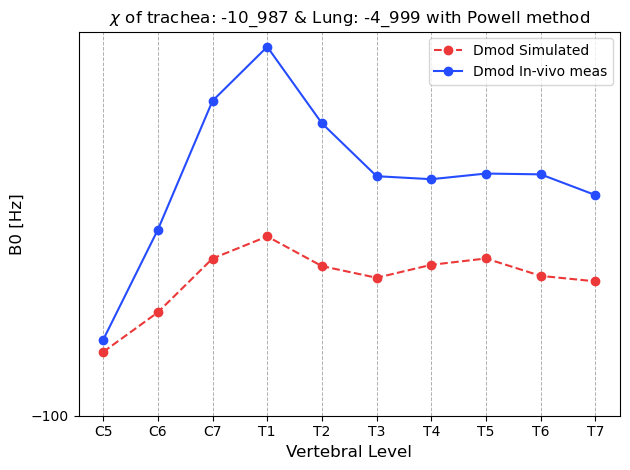

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #113
Chi for trachea: -10.991788860718398
Chi for lungs: -4.9991921151936545
For iteration #113 using -376.4043530326322
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_992_l_-4_999_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_992_l_-4_999_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_992_l_-4_999_Hz.csv

Total runtime; 9.828 seconds.

Difference:  249.26943631698288


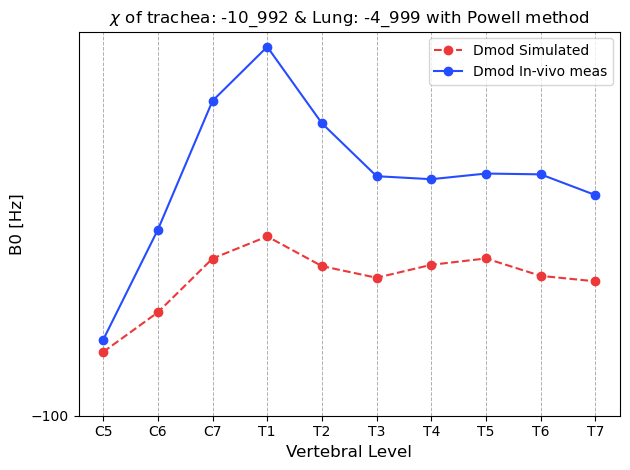

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #114
Chi for trachea: -10.99492523683761
Chi for lungs: -4.99947088959071
For iteration #114 using -376.4044036181876
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_995_l_-4_999_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_995_l_-4_999_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_995_l_-4_999_Hz.csv

Total runtime; 12.615 seconds.

Difference:  249.2665456459363


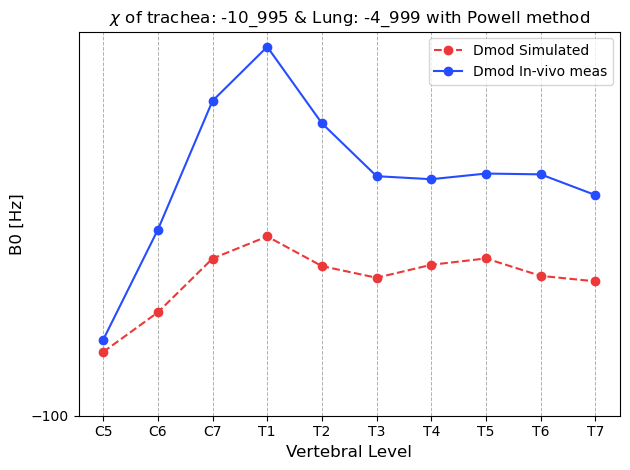

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #115
Chi for trachea: -10.996863623880786
Chi for lungs: -4.999643181643283
For iteration #115 using -376.4044348817801
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_997_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_997_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_997_l_-5_0_Hz.csv

Total runtime; 12.499 seconds.

Difference:  249.26475931834491


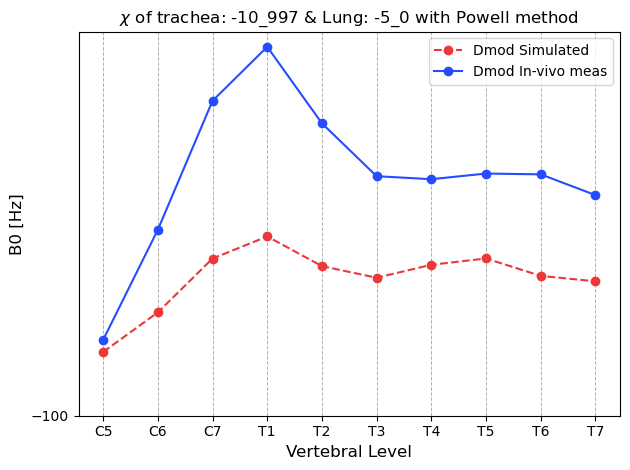

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #116
Chi for trachea: -10.998061612956823
Chi for lungs: -4.999749663987766
For iteration #116 using -376.40445420374283
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_998_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_998_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_998_l_-5_0_Hz.csv

Total runtime; 9.870 seconds.

Difference:  249.2636553856231


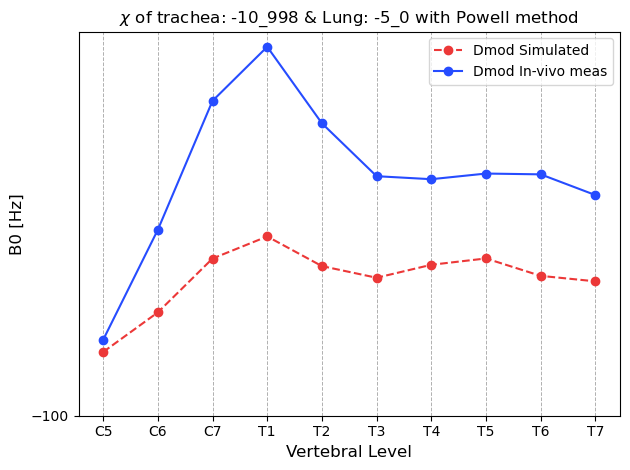

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #117
Chi for trachea: -10.998802010923963
Chi for lungs: -4.9998154736958575
For iteration #117 using -376.4044661453727
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_999_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-5_0_Hz.csv

Total runtime; 9.943 seconds.

Difference:  249.26297314764298


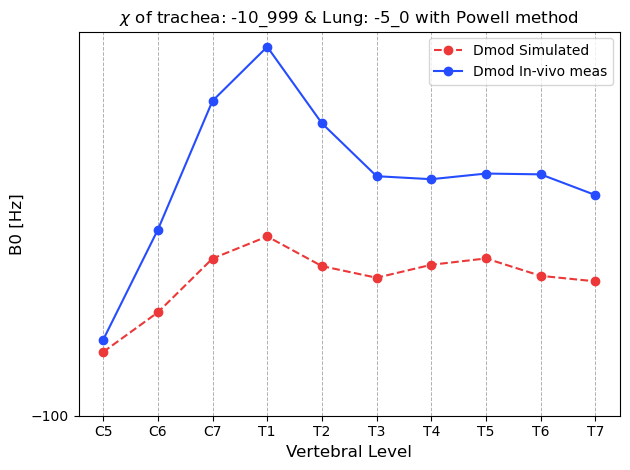

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #118
Chi for trachea: -10.99925960203286
Chi for lungs: -4.999856146332248
For iteration #118 using -376.40447352570567
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-10_999_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-10_999_l_-5_0_Hz.csv

Total runtime; 12.546 seconds.

Difference:  249.26255151282822


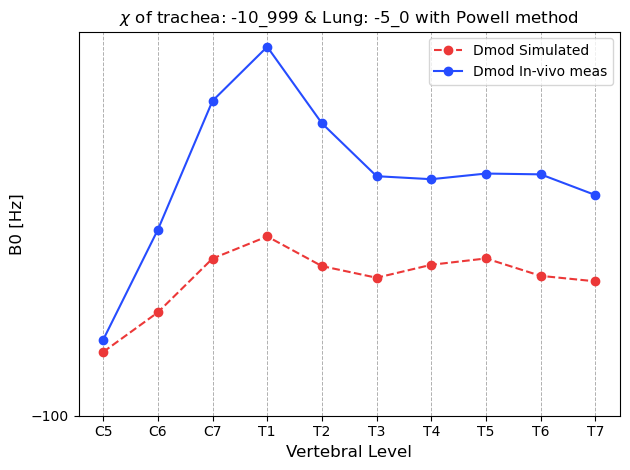

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #119
Chi for trachea: -10.999542408891106
Chi for lungs: -4.9998812834039486
For iteration #119 using -376.40447808700236
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 9.845 seconds.

Difference:  249.26229093255358


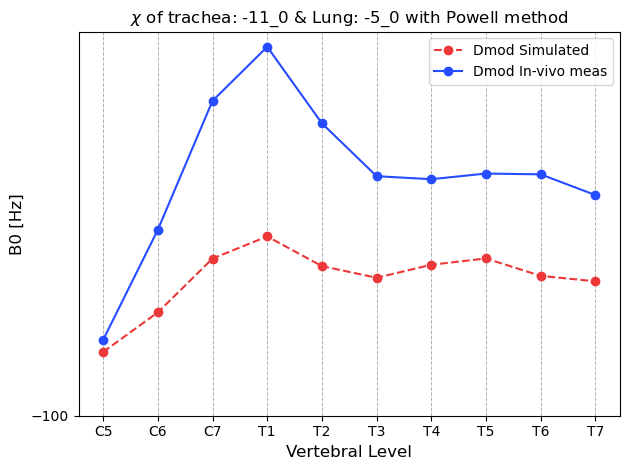

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #120
Chi for trachea: -10.999717193141754
Chi for lungs: -4.9998968189686375
For iteration #120 using -376.4044809060387
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 10.107 seconds.

Difference:  249.26212988675684


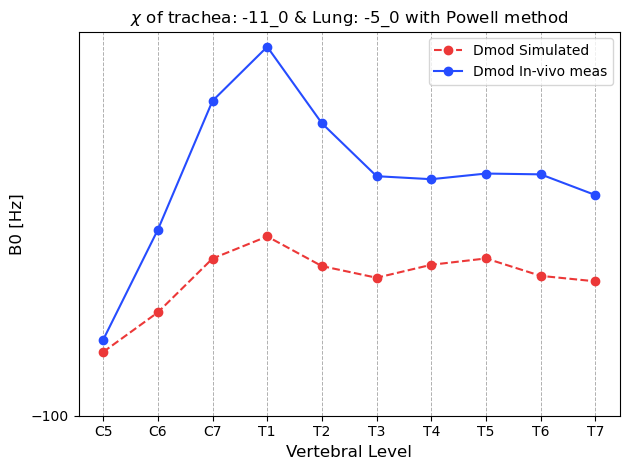

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #121
Chi for trachea: -10.999825215749352
Chi for lungs: -4.99990642047565
For iteration #121 using -376.40448264829905
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.558 seconds.

Difference:  249.26203035561846


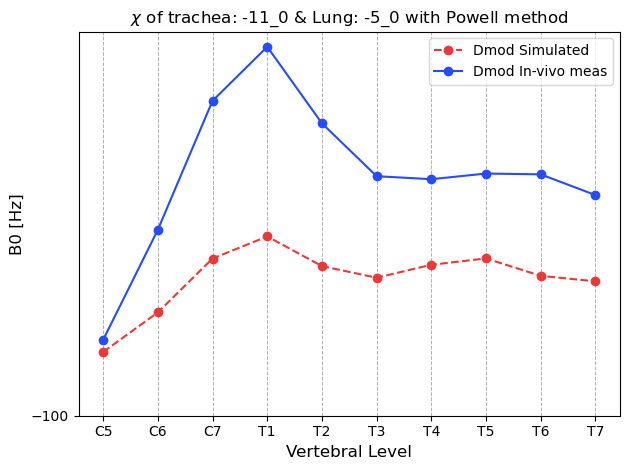

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #122
Chi for trachea: -10.999891977392402
Chi for lungs: -4.999912354533327
For iteration #122 using -376.4044837250751
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.850 seconds.

Difference:  249.2619688422357


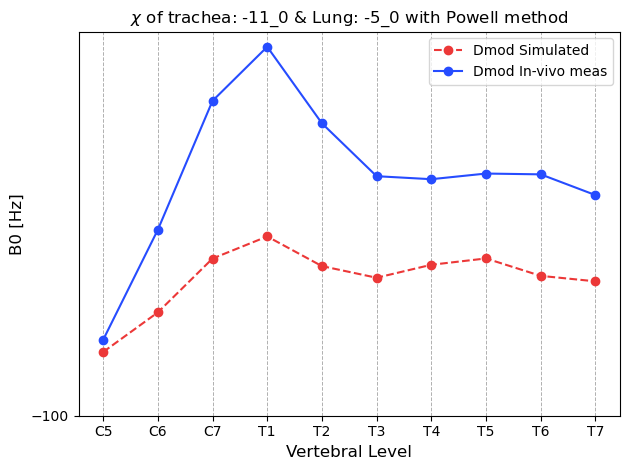

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #123
Chi for trachea: -10.99993323835695
Chi for lungs: -4.999916021982663
For iteration #123 using -376.40448439055933
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 10.154 seconds.

Difference:  249.26193082496744


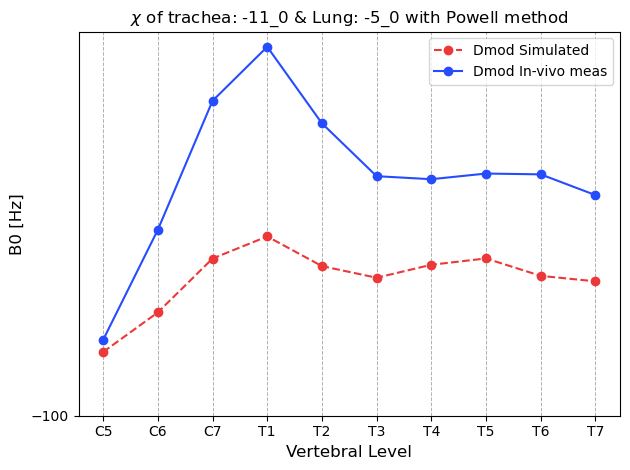

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #124
Chi for trachea: -10.999958739035451
Chi for lungs: -4.999918288591004
For iteration #124 using -376.4044848018512
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 10.706 seconds.

Difference:  249.26190732903905


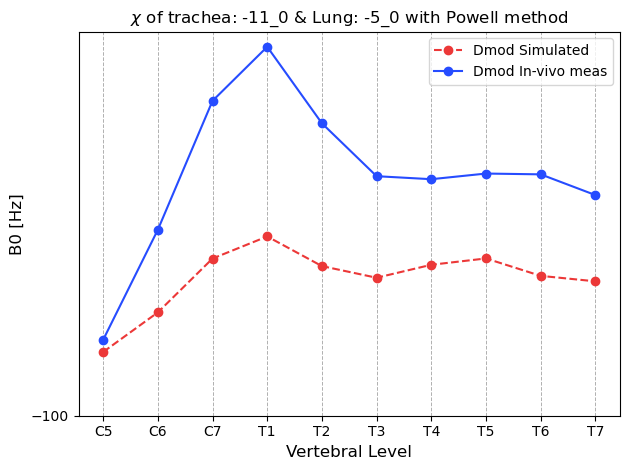

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #125
Chi for trachea: -10.9999744993215
Chi for lungs: -4.999919689431998
For iteration #125 using -376.4044850560436
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 10.239 seconds.

Difference:  249.26189280777012


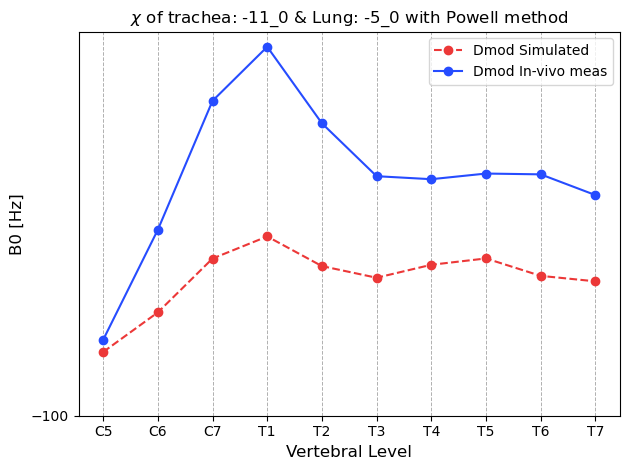

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #126
Chi for trachea: -10.999984239713951
Chi for lungs: -4.999920555199345
For iteration #126 using -376.4044852131431
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 10.286 seconds.

Difference:  249.2618838331377


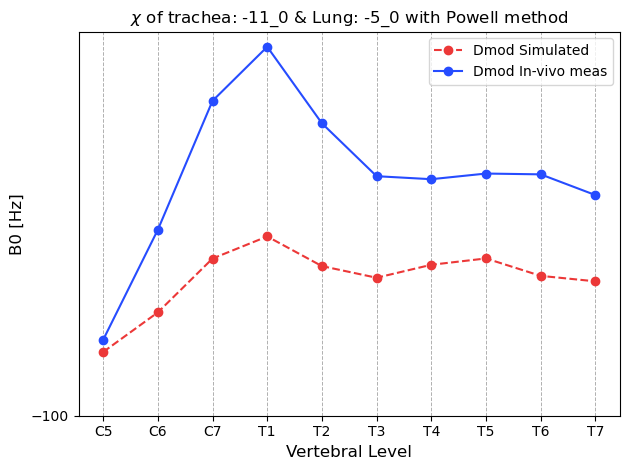

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #127
Chi for trachea: -10.999990259607548
Chi for lungs: -4.999921090272992
For iteration #127 using -376.40448531023594
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 10.332 seconds.

Difference:  249.26187828651177


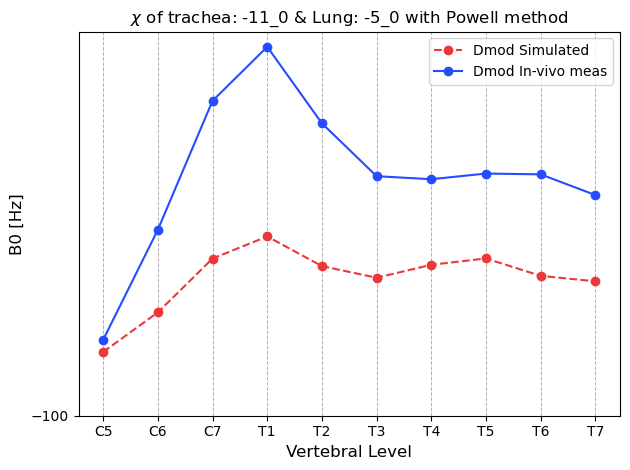

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #128
Chi for trachea: -10.999993980106401
Chi for lungs: -4.999921420966692
For iteration #128 using -376.40448537024264
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.524 seconds.

Difference:  249.26187485850915


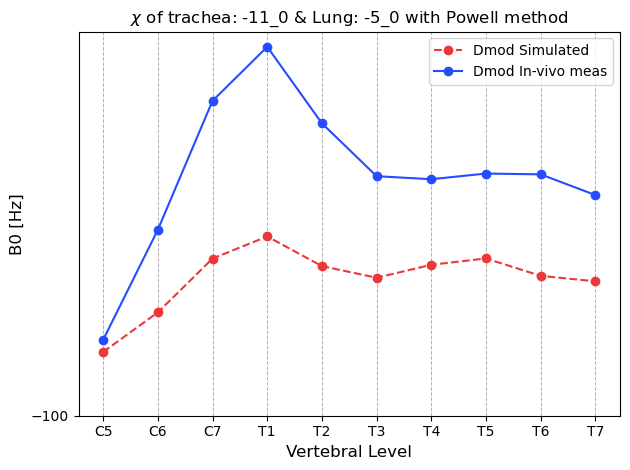

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #129
Chi for trachea: -10.999996279501147
Chi for lungs: -4.999921625346639
For iteration #129 using -376.4044854073287
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 16.507 seconds.

Difference:  249.26187273988754


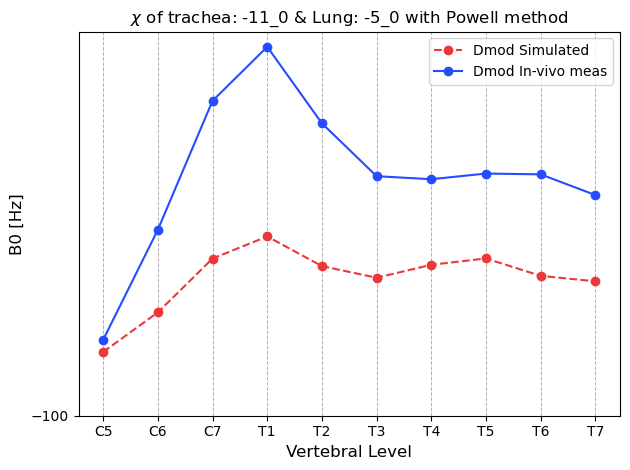

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #130
Chi for trachea: -10.999997700605254
Chi for lungs: -4.999921751660392
For iteration #130 using -376.40448543024934
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.957 seconds.

Difference:  249.2618714305071


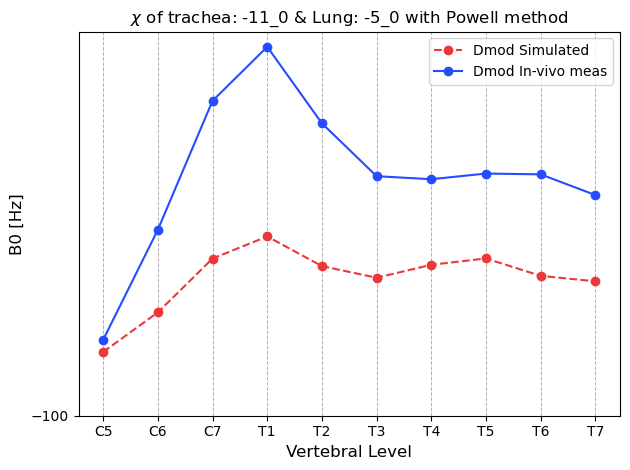

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #131
Chi for trachea: -10.999998578895893
Chi for lungs: -4.999921829726586
For iteration #131 using -376.40448544441495
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.916 seconds.

Difference:  249.26187062126584


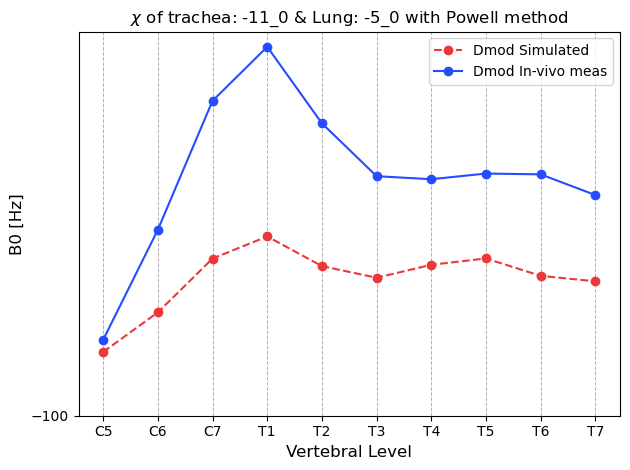

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #132
Chi for trachea: -10.99999912170936
Chi for lungs: -4.999921877974146
For iteration #132 using -376.40448545316974
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.610 seconds.

Difference:  249.2618701211272


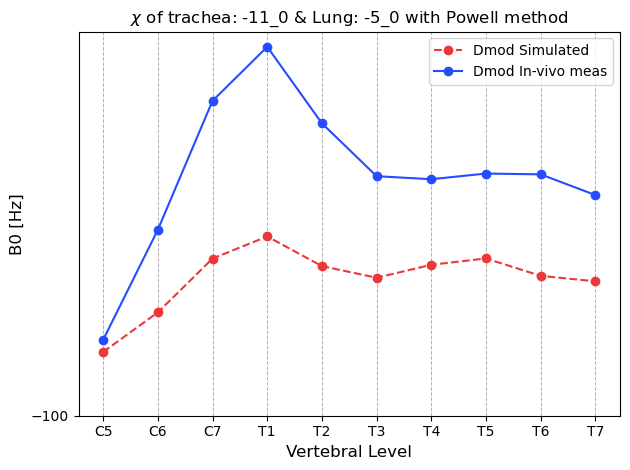

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #133
Chi for trachea: -10.999999457186533
Chi for lungs: -4.999921907792778
For iteration #133 using -376.4044854585806
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.516 seconds.

Difference:  249.26186981202434


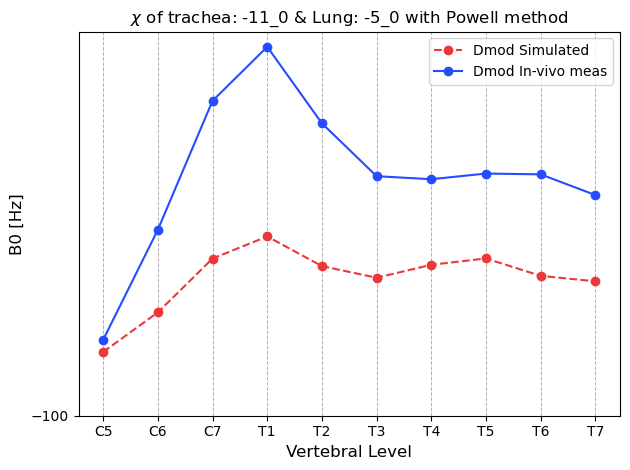

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #134
Chi for trachea: -10.999999664522829
Chi for lungs: -4.999921926221707
For iteration #134 using -376.4044854619247
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.588 seconds.

Difference:  249.26186962098834


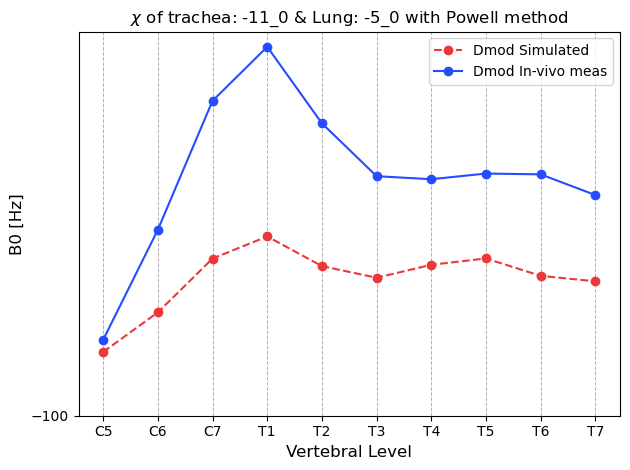

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #135
Chi for trachea: -10.999999792663704
Chi for lungs: -4.999921937611411
For iteration #135 using -376.40448546399136
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 16.186 seconds.

Difference:  249.2618695029218


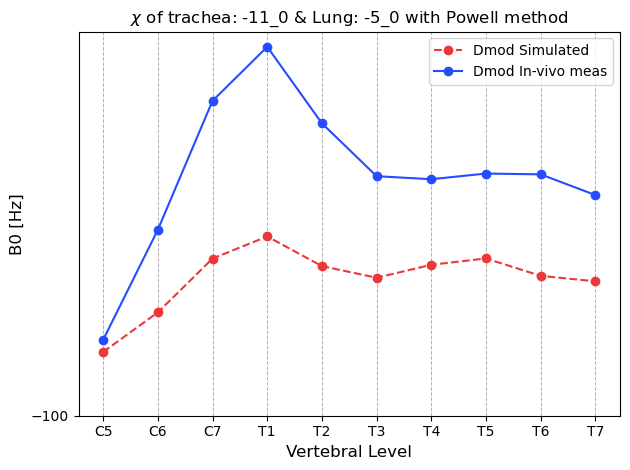

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #136
Chi for trachea: -10.999999871859123
Chi for lungs: -4.999921944650635
For iteration #136 using -376.40448546526875
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.595 seconds.

Difference:  249.26186942995238


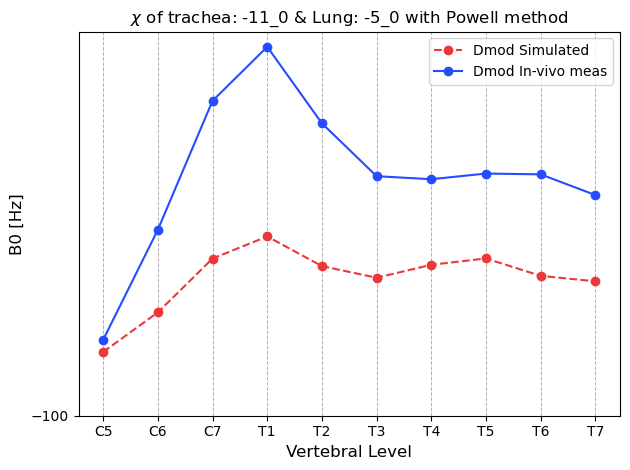

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #137
Chi for trachea: -10.999999920804582
Chi for lungs: -4.999921949001115
For iteration #137 using -376.4044854660581
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.845 seconds.

Difference:  249.26186938485512


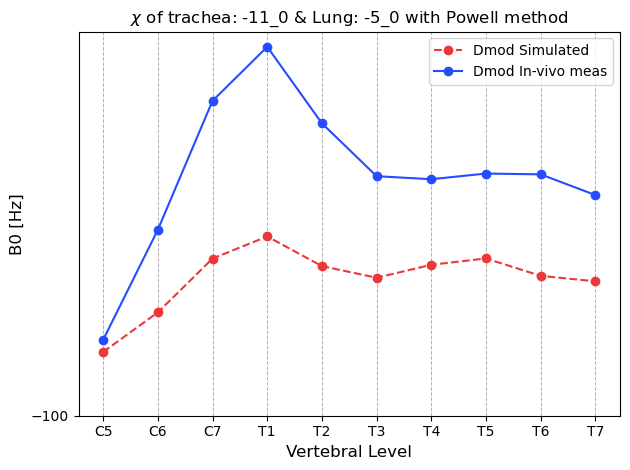

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #138
Chi for trachea: -10.99999995105454
Chi for lungs: -4.999921951689859
For iteration #138 using -376.404485466546
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.961 seconds.

Difference:  249.26186935698308


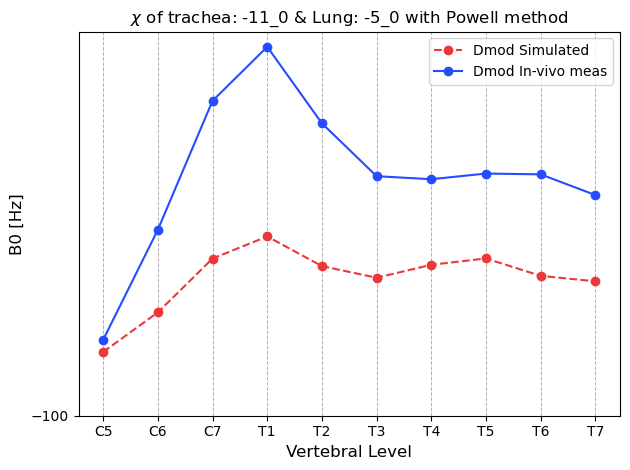

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #139
Chi for trachea: -10.999999969750043
Chi for lungs: -4.999921953351595
For iteration #139 using -376.4044854668476
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 11.903 seconds.

Difference:  249.2618693397575


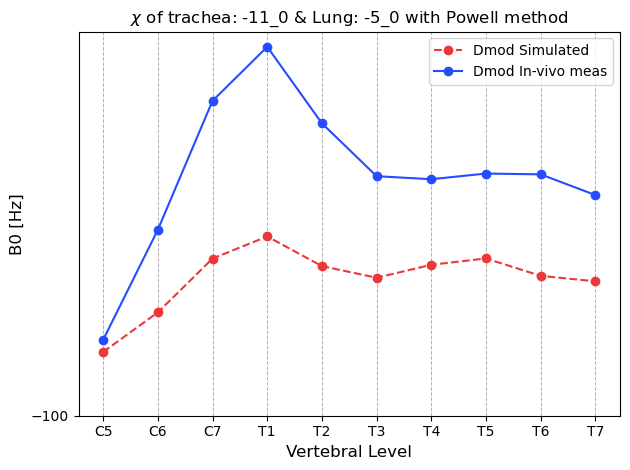

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #140
Chi for trachea: -10.999999982205155
Chi for lungs: -4.999921954458658
For iteration #140 using -376.40448546704846
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-11_0_l_-5_0_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 5:14 -vertfile E:\msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_033_dup1\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-11_0_l_-5_0_Hz.csv

Total runtime; 12.247 seconds.

Difference:  249.26186932828156


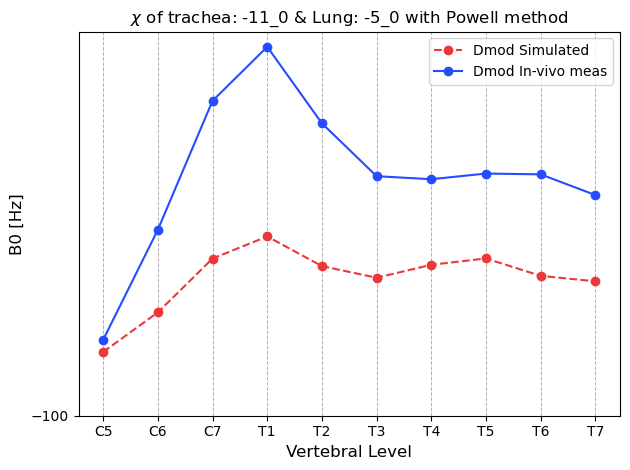

Optimization result:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 249.26186932828156
       x: [-1.100e+01 -5.000e+00]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00]
           [ 3.736e-04  3.321e-05]]
    nfev: 140
######## ############## ############### #############


In [37]:
# Set initial values, boundaries and run optimization
initial_values = [-2, -4.2] # Body should begin
# First bound is trachea // Depends on objective code !!!
# Second bound is Lung // Depends on objective code !!!
# Check the MD above!
bounds = [(-11, 0.2), (-5, 0.2)]

if counter != 0 :
        # This means that you forgot to change the folder run number, to avoid mixing tests, please run that cell 
        # Changing the number after run!
    print("Please change run # to avoid mixing result folders :)")
else:
    if not os.path.exists(path_to_iter_fms) or not os.path.exists(path_to_iter_metrics):
        print("Creating run folders")
        os.makedirs(path_to_iter_fms)
        os.makedirs(path_to_iter_metrics)
        print("Folders created: ", path_to_iter_fms)
    
    result = optimize.minimize(f_simple_double_opt, initial_values, bounds = bounds, method = 'Powell')

    # Output the result
    print("Optimization result:", result)
    print("######## ############## ############### #############")

<Figure size 640x480 with 0 Axes>

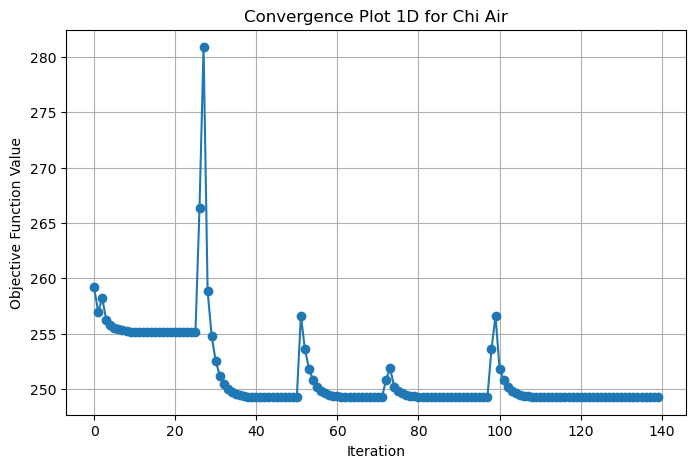

In [39]:
plt.figure()
chi_values_range = np.linspace(-1, 0.5, 100)

plt.figure(figsize=(8, 5))
plt.plot(history, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence Plot 1D for Chi Air")
plt.grid()
plt.show()

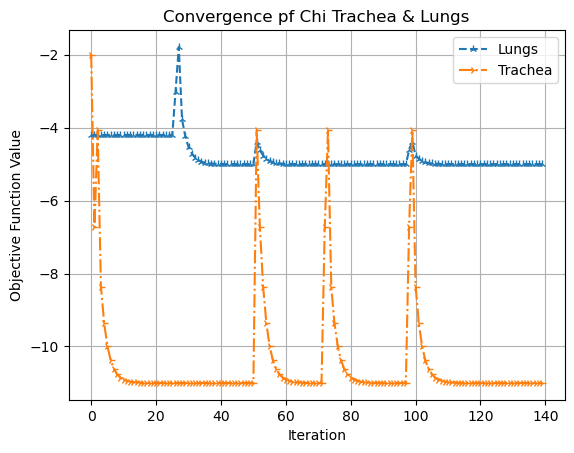

In [40]:
plt.figure()
chi_values_range = np.linspace(-1, 0.5, 100)
plt.plot(history_chi_lungs, marker='2', linestyle='--')
plt.plot(history_chi_trachea, marker='4', linestyle='-.')

plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence pf Chi Trachea & Lungs")
plt.legend(["Lungs", "Trachea"])
plt.grid()
plt.show()

 # <span style="color:#D8C40D6A"> *Metrics!* </span> </br>
 Let's analyze how much we've improved after optimization

In [38]:
worst_l2 = np.max(history)
print("Worst L2 norm: ", worst_l2)
best_l2 = np.min(history)
print("Best L2 norm: ", best_l2)

Worst L2 norm:  280.885377410653
Best L2 norm:  249.2616373227068
